In [2]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/MyDrive/task1_video_reviews"
data_dir    = f"{project_dir}/data"
out_dir     = f"{project_dir}/outputs"

import os, pathlib
os.makedirs(data_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

%cd $project_dir
print("Project:", project_dir)
print("Put your CSVs in:", data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/task1_video_reviews
Project: /content/drive/MyDrive/task1_video_reviews
Put your CSVs in: /content/drive/MyDrive/task1_video_reviews/data


In [3]:
import os, pandas as pd

labeled_df = pd.read_csv(f"{data_dir}/labeled-data.csv")
unlabeled_df = pd.read_csv(f"{data_dir}/unlabeled-data.csv")

In [4]:
labeled_df.head()

,review_text,review_score
0,"It&#146;s the best looking, most enticingly pu...",8
1,The Nintendo LABO Variety Kit has some fun and...,8
2,"But as far as sound investments go, buying up ...",8
3,"Starts out with a bang, but then quickly falls...",7
4,Valkyria Revolution tells a decent tale of war...,6


### Preprocess


In [5]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [6]:
import pandas as pd
import numpy as np
import string
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import nltk


ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def preprocessing(text, method='lemmatize'):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    if method == 'stem':
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    elif method == 'lemmatize':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


labeled_df['review_text_processed'] = labeled_df['review_text'].apply(preprocessing)
unlabeled_df['review_text_processed'] = unlabeled_df['review_text'].apply(preprocessing)
print("Sample processed labeled text:", labeled_df['review_text_processed'].iloc[0])
print("Sample processed unlabeled text:", unlabeled_df['review_text_processed'].iloc[0])


Sample processed labeled text: best looking enticingly put together football game year playing enjoyable watching jet get mauled first week season
Sample processed unlabeled text: leaning heavily traditional jhorror convention deliver scare suspense calling creates captivating dark atmosphere manages connect gamers psyche way make whole greater sum part


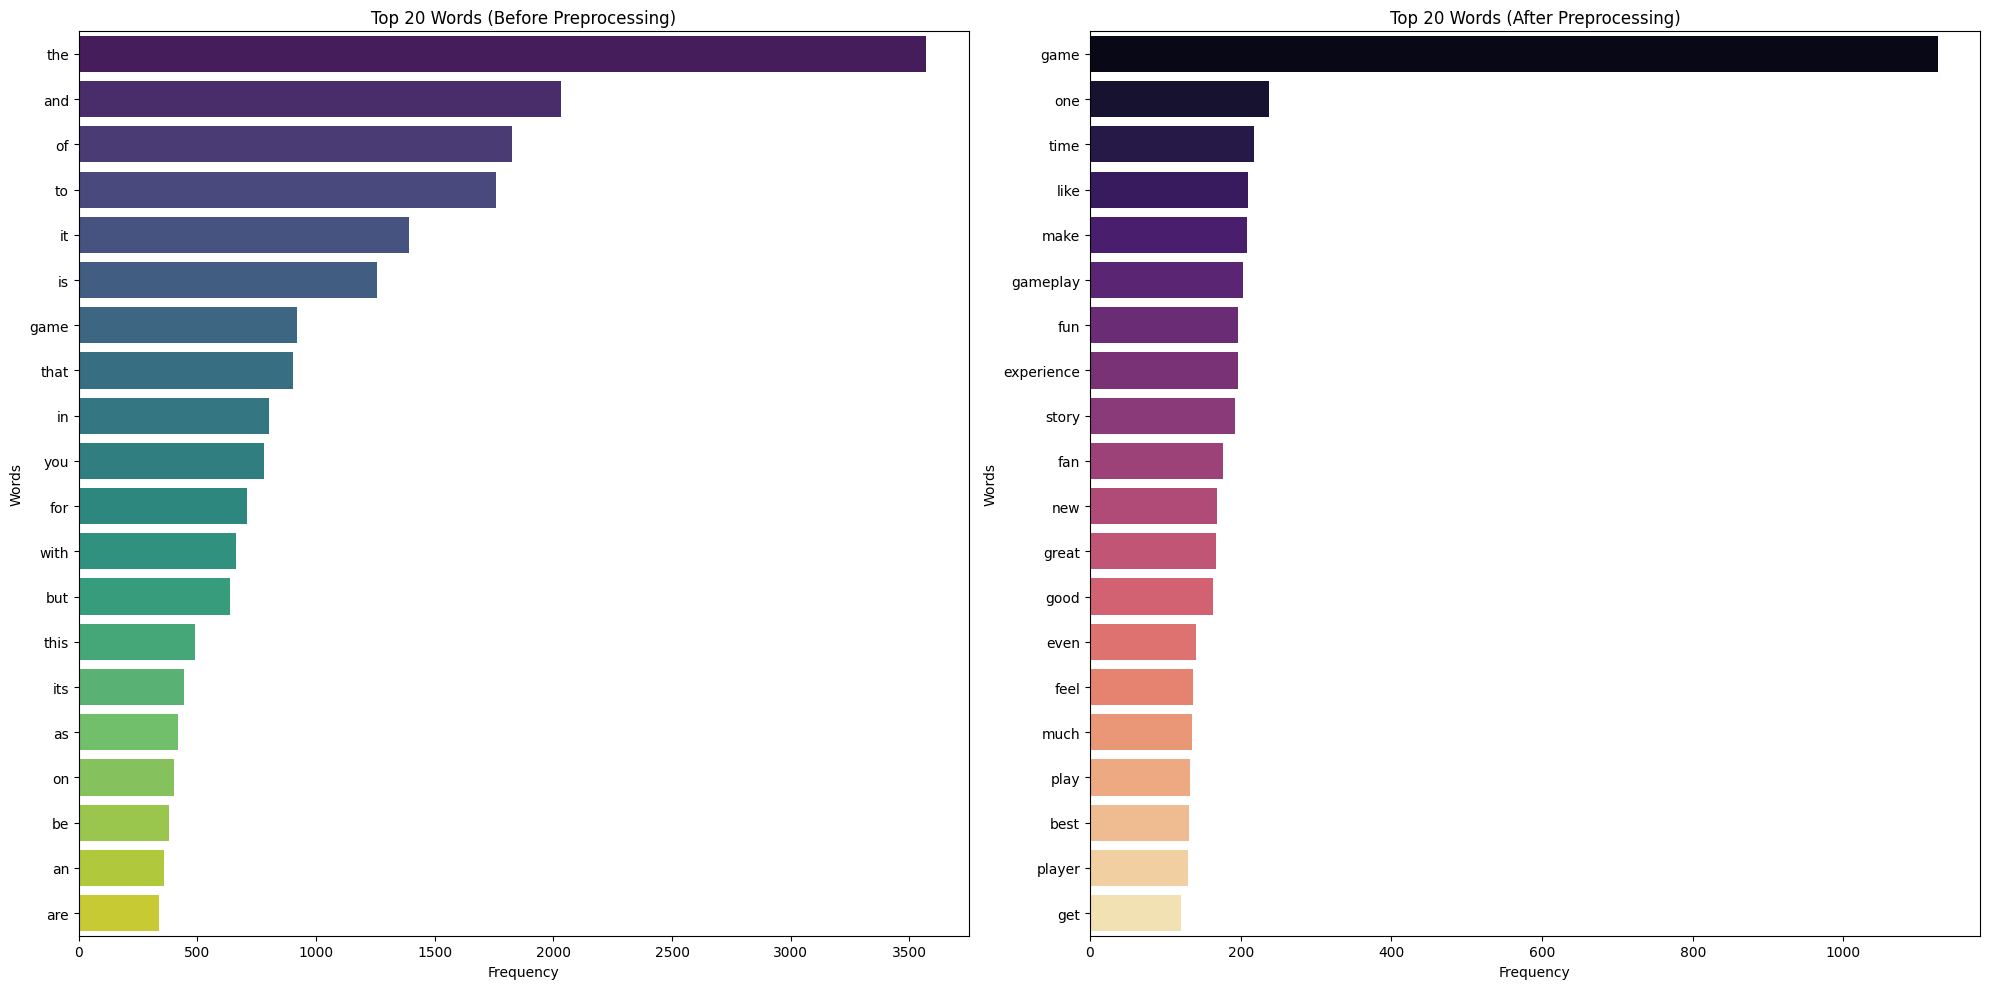

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

original_texts = labeled_df['review_text'].tolist()

vectorizer_raw = CountVectorizer()
X_raw = vectorizer_raw.fit_transform(original_texts)

raw_word_counts = pd.DataFrame(X_raw.toarray(), columns=vectorizer_raw.get_feature_names_out())
raw_freq = raw_word_counts.sum().sort_values(ascending=False).head(20)

processed_texts = labeled_df['review_text_processed'].tolist()

vectorizer_processed = CountVectorizer()
X_processed = vectorizer_processed.fit_transform(processed_texts)

processed_word_counts = pd.DataFrame(X_processed.toarray(), columns=vectorizer_processed.get_feature_names_out())
processed_freq = processed_word_counts.sum().sort_values(ascending=False).head(20)


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.barplot(x=raw_freq.values, y=raw_freq.index, hue=raw_freq.index, palette='viridis', legend=False)
plt.title('Top 20 Words (Before Preprocessing)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(1, 2, 2)
sns.barplot(x=processed_freq.values, y=processed_freq.index, hue=processed_freq.index, palette='magma', legend=False)
plt.title('Top 20 Words (After Preprocessing)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.tight_layout()
plt.show()

### SentenceTransformer (Semantic Embeddings):

In [8]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded successfully!


In [9]:
import numpy as np

labeled_embeddings = model.encode(labeled_df['review_text_processed'].tolist(), show_progress_bar=True)
np.save('labeled_embeddings_sentence.npy', labeled_embeddings)
print("Labeled embeddings shape:", labeled_embeddings.shape)

unlabeled_embeddings = model.encode(unlabeled_df['review_text_processed'].tolist(), show_progress_bar=True)
np.save('unlabeled_embeddings_sentence.npy', unlabeled_embeddings)
print("Unlabeled embeddings shape:", unlabeled_embeddings.shape)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Labeled embeddings shape: (1250, 384)


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Unlabeled embeddings shape: (5000, 384)


In [10]:
!pip install gensim

### Word2Vec (Distributed Word Representations):

In [11]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

all_texts_processed = pd.concat([labeled_df['review_text_processed'], unlabeled_df['review_text_processed']]).tolist()
tokenized_texts = [simple_preprocess(text) for text in all_texts_processed if text]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=300, window=5, min_count=1, workers=4)
w2v_model.save('word2vec_model.bin')
print("Word2Vec model trained!")

def get_sentence_embedding(text, model):
    words = simple_preprocess(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

labeled_embeddings_w2v = np.array([get_sentence_embedding(text, w2v_model) for text in labeled_df['review_text_processed']])
np.save('labeled_embeddings_w2v.npy', labeled_embeddings_w2v)
print("Labeled W2V embeddings shape:", labeled_embeddings_w2v.shape)

unlabeled_embeddings_w2v = np.array([get_sentence_embedding(text, w2v_model) for text in unlabeled_df['review_text_processed']])
np.save('unlabeled_embeddings_w2v.npy', unlabeled_embeddings_w2v)
print("Unlabeled W2V embeddings shape:", unlabeled_embeddings_w2v.shape)

Word2Vec model trained!
Labeled W2V embeddings shape: (1250, 300)
Unlabeled W2V embeddings shape: (5000, 300)


### Dimensionality Reduction and Visualization:

SentenceTransformer embeddings shape: (1250, 384)
Reduced embeddings shape: (1250, 2)
Explained variance ratio: [0.03322943 0.0284522 ]


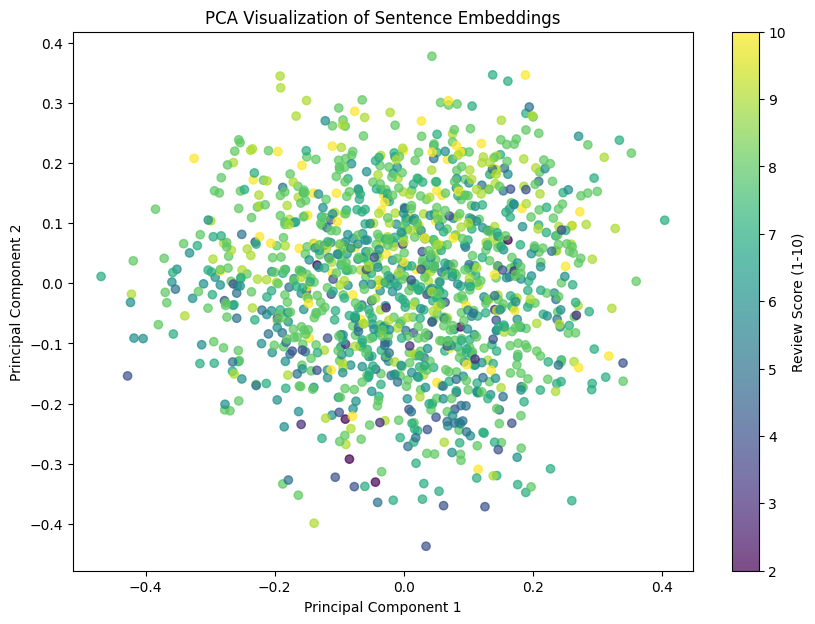

In [12]:
labeled_embeddings = np.load('labeled_embeddings_sentence.npy')
print("SentenceTransformer embeddings shape:", labeled_embeddings.shape)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(labeled_embeddings)
print("Reduced embeddings shape:", reduced_embeddings.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)

import matplotlib.pyplot as plt

scores = labeled_df['review_score'].values

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=scores, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Review Score (1-10)')
plt.title('PCA Visualization of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('pca_plot_sentence.png')
plt.show()

Word2Vec embeddings shape: (1250, 300)
Reduced W2V shape: (1250, 2)
Explained variance ratio (W2V): [0.9972027  0.00115793]


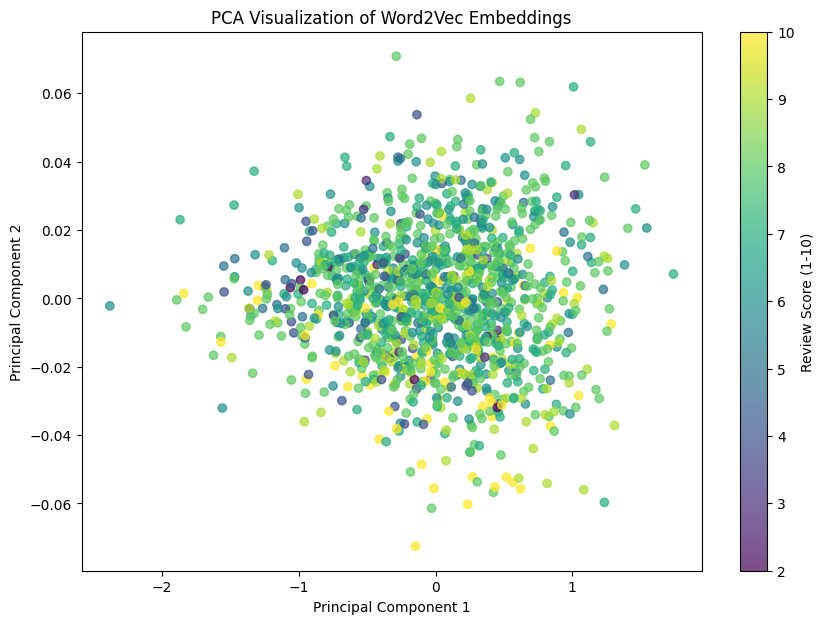

In [13]:
labeled_embeddings_w2v = np.load('labeled_embeddings_w2v.npy')
print("Word2Vec embeddings shape:", labeled_embeddings_w2v.shape)

reduced_embeddings_w2v = pca.fit_transform(labeled_embeddings_w2v)
print("Reduced W2V shape:", reduced_embeddings_w2v.shape)
print("Explained variance ratio (W2V):", pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings_w2v[:, 0], reduced_embeddings_w2v[:, 1], c=scores, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Review Score (1-10)')
plt.title('PCA Visualization of Word2Vec Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('pca_plot_w2v.png')
plt.show()

## Supervised Learning Baselines

In [14]:
from sklearn.model_selection import train_test_split

X = np.load('labeled_embeddings_sentence.npy')
y = labeled_df['review_score'].values
print("Embeddings shape:", X.shape)
print("Scores shape:", y.shape)

class_counts = pd.Series(y).value_counts()
print("Score distribution:", class_counts)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Temp shape:", X_temp.shape, y_temp.shape)

temp_class_counts = pd.Series(y_temp).value_counts()
print("Temp score distribution:", temp_class_counts)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Embeddings shape: (1250, 384)
Scores shape: (1250,)
Score distribution: 8     452
7     241
6     188
9     162
10     71
5      66
4      52
3      12
2       6
Name: count, dtype: int64
Temp shape: (250, 384) (250,)
Temp score distribution: 8     91
7     48
6     38
9     33
10    14
5     13
4     10
3      2
2      1
Name: count, dtype: int64
Train shapes: (1000, 384) (1000,)
Validation shapes: (125, 384) (125,)
Test shapes: (125, 384) (125,)


In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
print("Logistic Regression trained!")

y_train_pred_clf = clf.predict(X_train)
y_val_pred_clf = clf.predict(X_val)
y_test_pred_clf = clf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression trained!


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"{set_name} Metrics (Logistic Regression):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print()

print_metrics(y_train, y_train_pred_clf, "Training")
print_metrics(y_val, y_val_pred_clf, "Validation")
print_metrics(y_test, y_test_pred_clf, "Test")

Training Metrics (Logistic Regression):
Accuracy: 0.4750
Precision (macro): 0.3718
Recall (macro): 0.1999
F1-score (macro): 0.1996
MAE: 0.9270
MSE: 2.1790
RMSE: 1.4761
R²: 0.0515

Validation Metrics (Logistic Regression):
Accuracy: 0.3760
Precision (macro): 0.1917
Recall (macro): 0.1514
F1-score (macro): 0.1355
MAE: 1.0160
MSE: 2.1200
RMSE: 1.4560
R²: -0.0551

Test Metrics (Logistic Regression):
Accuracy: 0.3360
Precision (macro): 0.0783
Recall (macro): 0.1202
F1-score (macro): 0.0872
MAE: 1.1200
MSE: 2.5440
RMSE: 1.5950
R²: -0.0661



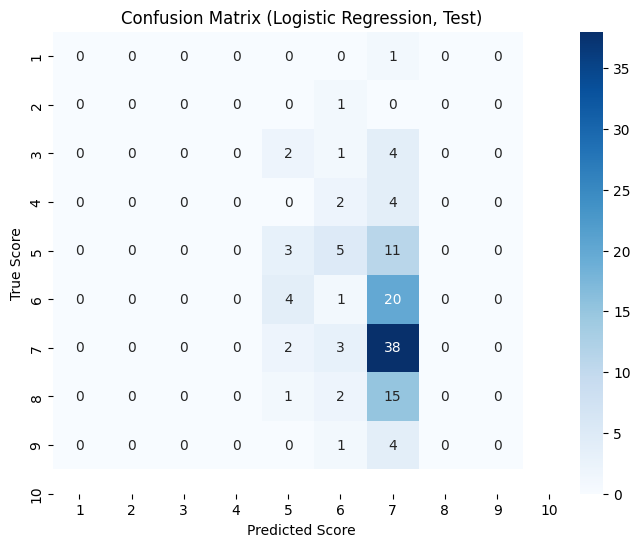

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 11), yticklabels=range(1, 11))
    plt.title(f'Confusion Matrix (Logistic Regression, {set_name})')
    plt.xlabel('Predicted Score')
    plt.ylabel('True Score')
    plt.savefig(f'confusion_matrix_clf_{set_name.lower()}.png')
    plt.show()

# plot_confusion_matrix(y_train, y_train_pred_clf, "Training")
# plot_confusion_matrix(y_val, y_val_pred_clf, "Validation")
plot_confusion_matrix(y_test, y_test_pred_clf, "Test")

In [19]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
print("Linear Regression trained!")

y_train_pred_reg = reg.predict(X_train)
y_val_pred_reg = reg.predict(X_val)
y_test_pred_reg = reg.predict(X_test)
y_train_pred_reg_rounded = np.clip(np.round(y_train_pred_reg), 1, 10).astype(int)
y_val_pred_reg_rounded = np.clip(np.round(y_val_pred_reg), 1, 10).astype(int)
y_test_pred_reg_rounded = np.clip(np.round(y_test_pred_reg), 1, 10).astype(int)

Linear Regression trained!


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_regression_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} Metrics (Linear Regression):")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print()

def print_reg_clf_metrics(y_true, y_pred_rounded, set_name):
    accuracy = accuracy_score(y_true, y_pred_rounded)
    precision = precision_score(y_true, y_pred_rounded, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred_rounded, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred_rounded, average='macro', zero_division=0)
    print(f"{set_name} Metrics (Linear Regression, Classification):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print()


print_regression_metrics(y_train, y_train_pred_reg, "Training")
print_reg_clf_metrics(y_train, y_train_pred_reg_rounded, "Training")
print_regression_metrics(y_val, y_val_pred_reg, "Validation")
print_reg_clf_metrics(y_val, y_val_pred_reg_rounded, "Validation")
print_regression_metrics(y_test, y_test_pred_reg, "Test")
print_reg_clf_metrics(y_test, y_test_pred_reg_rounded, "Test")

Training Metrics (Linear Regression):
MAE: 0.7641
MSE: 0.9298
RMSE: 0.9642
R²: 0.5953

Training Metrics (Linear Regression, Classification):
Accuracy: 0.4140
Precision (macro): 0.3324
Recall (macro): 0.2756
F1-score (macro): 0.2837

Validation Metrics (Linear Regression):
MAE: 1.1906
MSE: 2.2325
RMSE: 1.4942
R²: -0.1112

Validation Metrics (Linear Regression, Classification):
Accuracy: 0.3040
Precision (macro): 0.1539
Recall (macro): 0.1730
F1-score (macro): 0.1613

Test Metrics (Linear Regression):
MAE: 1.2863
MSE: 2.4950
RMSE: 1.5796
R²: -0.0456

Test Metrics (Linear Regression, Classification):
Accuracy: 0.2480
Precision (macro): 0.2019
Recall (macro): 0.1816
F1-score (macro): 0.1811



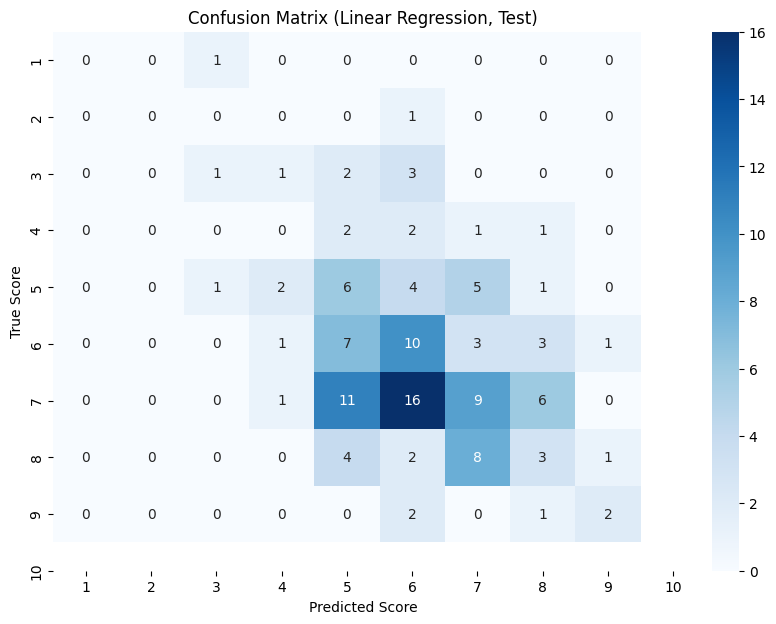

In [21]:
def plot_confusion_matrix_reg(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 11), yticklabels=range(1, 11))
    plt.title(f'Confusion Matrix (Linear Regression, {set_name})')
    plt.xlabel('Predicted Score')
    plt.ylabel('True Score')
    plt.savefig(f'confusion_matrix_reg_{set_name.lower()}.png')
    plt.show()

# plot_confusion_matrix_reg(y_train, y_train_pred_reg_rounded, "Training")
# plot_confusion_matrix_reg(y_val, y_val_pred_reg_rounded, "Validation")
plot_confusion_matrix_reg(y_test, y_test_pred_reg_rounded, "Test")

In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle


# Functions for metrics and plots
def print_regression_metrics(y_true, y_pred, set_name, iteration):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} Metrics (Linear Regression, Iteration {iteration}):")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print()
    return mae, mse, rmse, r2

def print_reg_clf_metrics(y_true, y_pred_rounded, set_name, iteration):
    accuracy = accuracy_score(y_true, y_pred_rounded)
    precision = precision_score(y_true, y_pred_rounded, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred_rounded, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred_rounded, average='macro', zero_division=0)
    print(f"{set_name} Metrics (Linear Regression, Classification, Iteration {iteration}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print()
    return accuracy, precision, recall, f1

def plot_confusion_matrix_reg(y_true, y_pred_rounded, set_name, iteration):
    cm = confusion_matrix(y_true, y_pred_rounded)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 11), yticklabels=range(1, 11))
    plt.title(f'Confusion Matrix (Linear Regression, {set_name}, Iteration {iteration})')
    plt.xlabel('Predicted Score')
    plt.ylabel('True Score')
    filename = f'confusion_matrix_reg_pseudo_{set_name.lower()}_iter{iteration}.png'
    plt.savefig(filename)
    print(f"Saved confusion matrix: {filename}")
    if display_plots:
        plt.show()
    plt.close()

def compute_roc_auc(y_true, y_score, iteration):
    classes = np.unique(np.concatenate((y_true, y_train_expanded)))
    y_true_bin = label_binarize(y_true, classes=classes)
    fpr, tpr, roc_auc = {}, {}, {}
    for i, cls in enumerate(classes):
        if np.sum(y_true_bin[:, i]) == 0:  # No positive samples
            fpr[cls], tpr[cls], roc_auc[cls] = [0, 1], [0, 0], 0.0
        else:
            fpr[cls], tpr[cls], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[cls] = auc(fpr[cls], tpr[cls])
    macro_auc = np.mean([roc_auc[cls] for cls in classes if roc_auc[cls] > 0])
    return fpr, tpr, roc_auc, macro_auc, classes

def plot_roc_curves(fpr, tpr, roc_auc, classes, iteration):
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for cls, color in zip(classes, colors):
        plt.plot(fpr[cls], tpr[cls], color=color, lw=2, label=f'Class {cls} (AUC = {roc_auc[cls]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves: Pseudo-Labeling (Iteration {iteration})')
    plt.legend(loc='lower right')
    filename = f'roc_pseudo_labeling_iter{iteration}.png'
    plt.savefig(filename)
    print(f"Saved ROC curve: {filename}")
    if display_plots:
        plt.show()
    plt.close()


Unlabeled embeddings shape: (5000, 384)

--- Iteration 1 ---
Selected 3032 pseudo-labeled samples (threshold: 0.3)
Expanded training set size: 4032
Remaining unlabeled pool size: 1968
Linear Regression retrained (Iteration 1)
Validation Metrics (Linear Regression, Iteration 1):
MAE: 1.1809
MSE: 2.1963
RMSE: 1.4820
R²: -0.0931

Test Metrics (Linear Regression, Iteration 1):
MAE: 1.2779
MSE: 2.4592
RMSE: 1.5682
R²: -0.0305

Validation Metrics (Linear Regression, Classification, Iteration 1):
Accuracy: 0.2880
Precision (macro): 0.1435
Recall (macro): 0.1620
F1-score (macro): 0.1506

Test Metrics (Linear Regression, Classification, Iteration 1):
Accuracy: 0.2400
Precision (macro): 0.1843
Recall (macro): 0.1773
F1-score (macro): 0.1691

Saved ROC curve: roc_pseudo_labeling_iter1.png


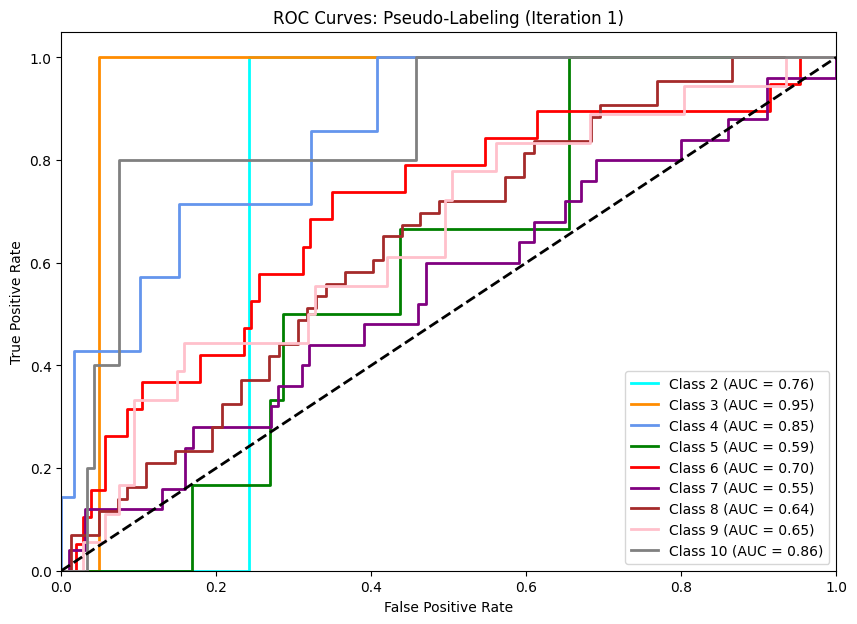

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter1.png


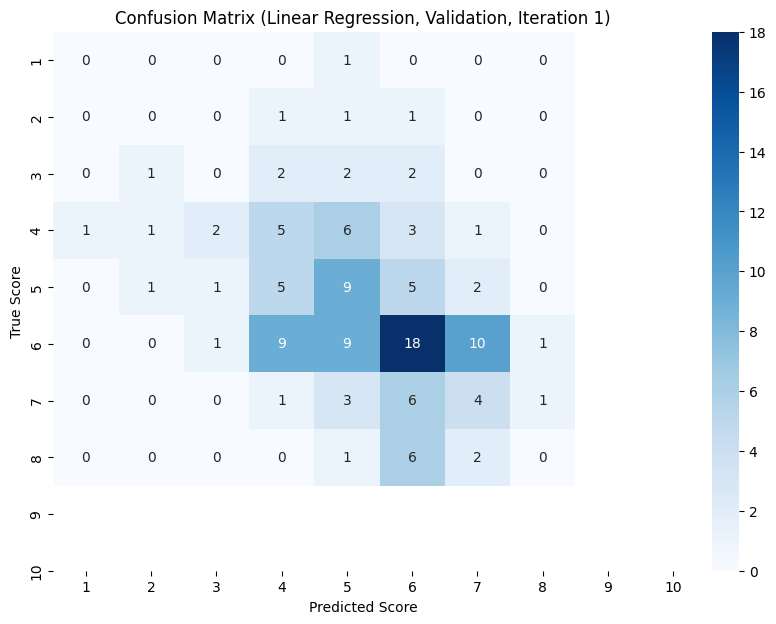

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter1.png


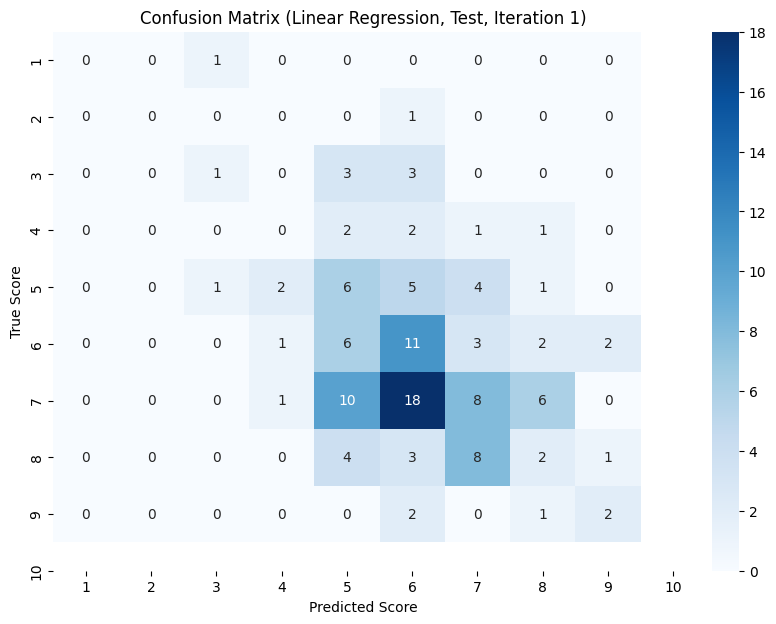

New best model saved (Test MAE: 1.2779)

--- Iteration 2 ---
Selected 111 pseudo-labeled samples (threshold: 0.27)
Expanded training set size: 4143
Remaining unlabeled pool size: 1857
Linear Regression retrained (Iteration 2)
Validation Metrics (Linear Regression, Iteration 2):
MAE: 1.1792
MSE: 2.1932
RMSE: 1.4809
R²: -0.0915

Test Metrics (Linear Regression, Iteration 2):
MAE: 1.2733
MSE: 2.4404
RMSE: 1.5622
R²: -0.0227

Validation Metrics (Linear Regression, Classification, Iteration 2):
Accuracy: 0.2720
Precision (macro): 0.1351
Recall (macro): 0.1511
F1-score (macro): 0.1415

Test Metrics (Linear Regression, Classification, Iteration 2):
Accuracy: 0.2400
Precision (macro): 0.2038
Recall (macro): 0.1773
F1-score (macro): 0.1715

Saved ROC curve: roc_pseudo_labeling_iter2.png


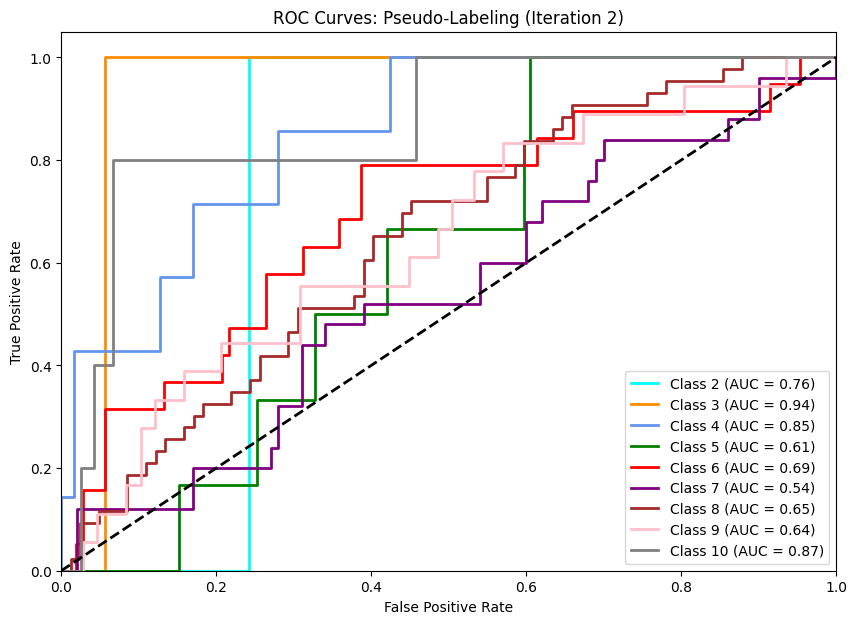

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter2.png


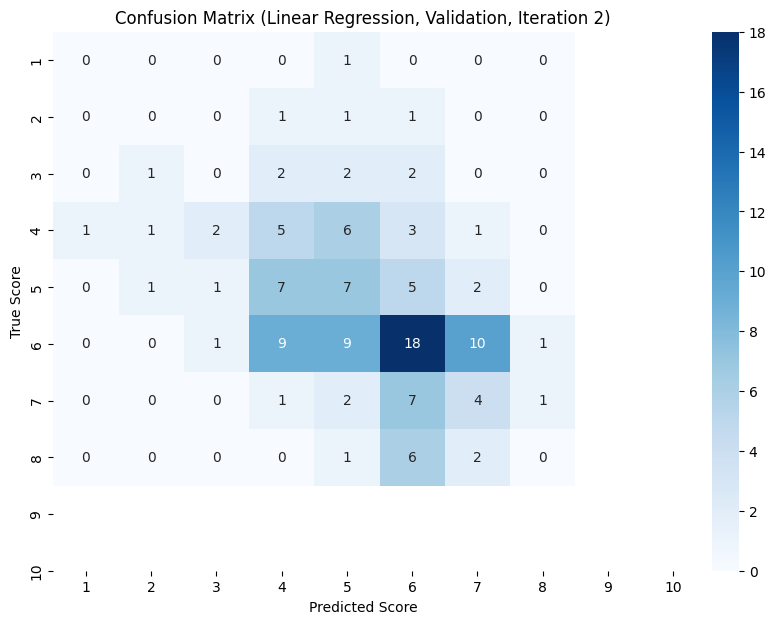

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter2.png


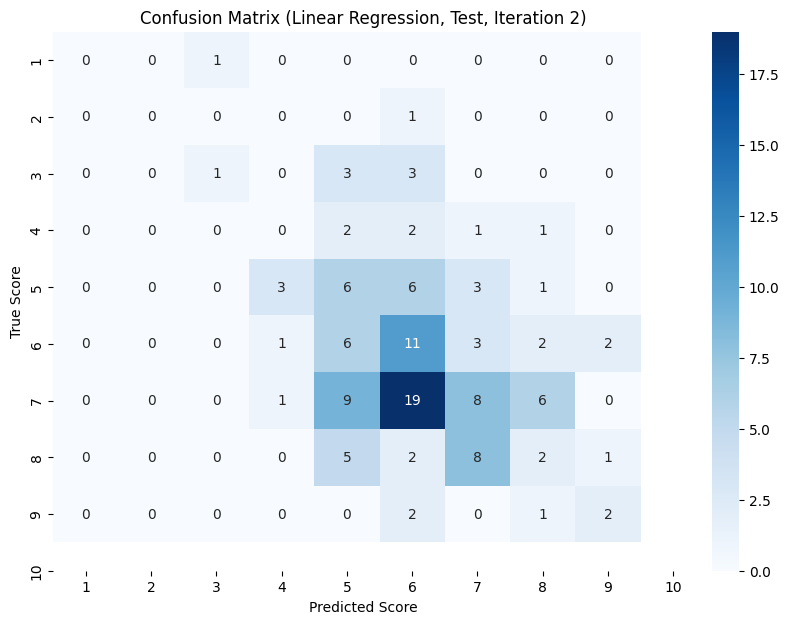

New best model saved (Test MAE: 1.2733)

--- Iteration 3 ---
Selected 3 pseudo-labeled samples (threshold: 0.24300000000000002)
Expanded training set size: 4146
Remaining unlabeled pool size: 1854
Linear Regression retrained (Iteration 3)
Validation Metrics (Linear Regression, Iteration 3):
MAE: 1.1792
MSE: 2.1930
RMSE: 1.4809
R²: -0.0915

Test Metrics (Linear Regression, Iteration 3):
MAE: 1.2734
MSE: 2.4407
RMSE: 1.5623
R²: -0.0228

Validation Metrics (Linear Regression, Classification, Iteration 3):
Accuracy: 0.2720
Precision (macro): 0.1351
Recall (macro): 0.1511
F1-score (macro): 0.1412

Test Metrics (Linear Regression, Classification, Iteration 3):
Accuracy: 0.2400
Precision (macro): 0.2038
Recall (macro): 0.1773
F1-score (macro): 0.1715

Saved ROC curve: roc_pseudo_labeling_iter3.png


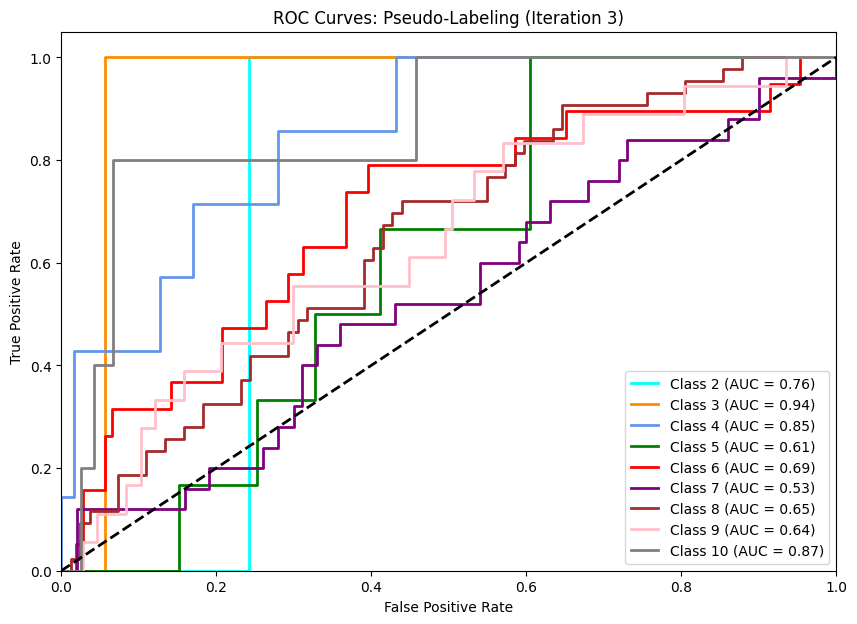

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter3.png


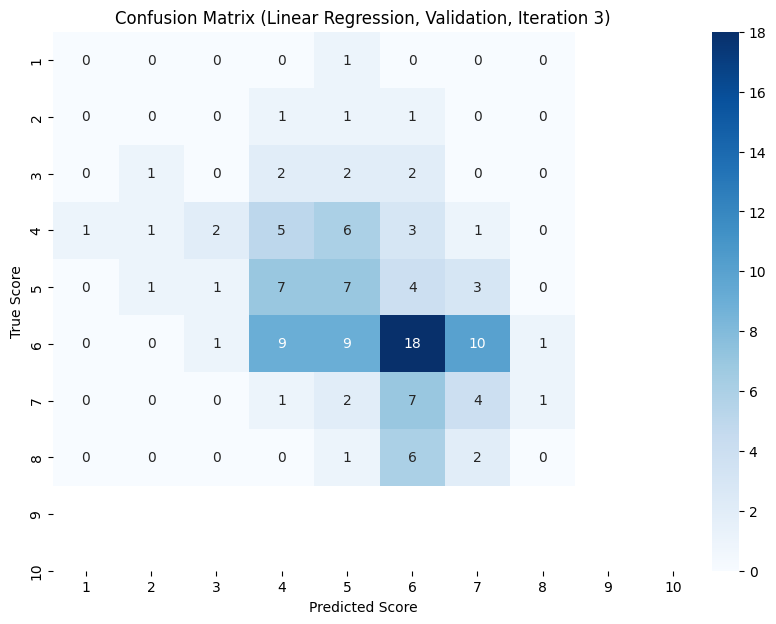

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter3.png


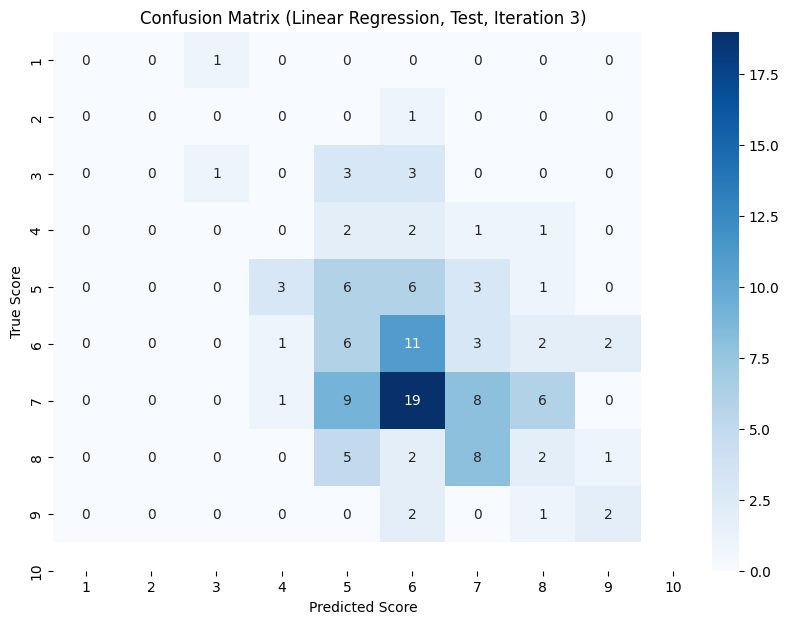

Performance did not improve. Stopping iterations.

--- Final Evaluation (Best Pseudo-Labeling Model) ---
Validation Metrics (Linear Regression, Iteration Final):
MAE: 1.1792
MSE: 2.1932
RMSE: 1.4809
R²: -0.0915

Test Metrics (Linear Regression, Iteration Final):
MAE: 1.2733
MSE: 2.4404
RMSE: 1.5622
R²: -0.0227

Validation Metrics (Linear Regression, Classification, Iteration Final):
Accuracy: 0.2720
Precision (macro): 0.1351
Recall (macro): 0.1511
F1-score (macro): 0.1415

Test Metrics (Linear Regression, Classification, Iteration Final):
Accuracy: 0.2400
Precision (macro): 0.2038
Recall (macro): 0.1773
F1-score (macro): 0.1715

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iterFinal.png


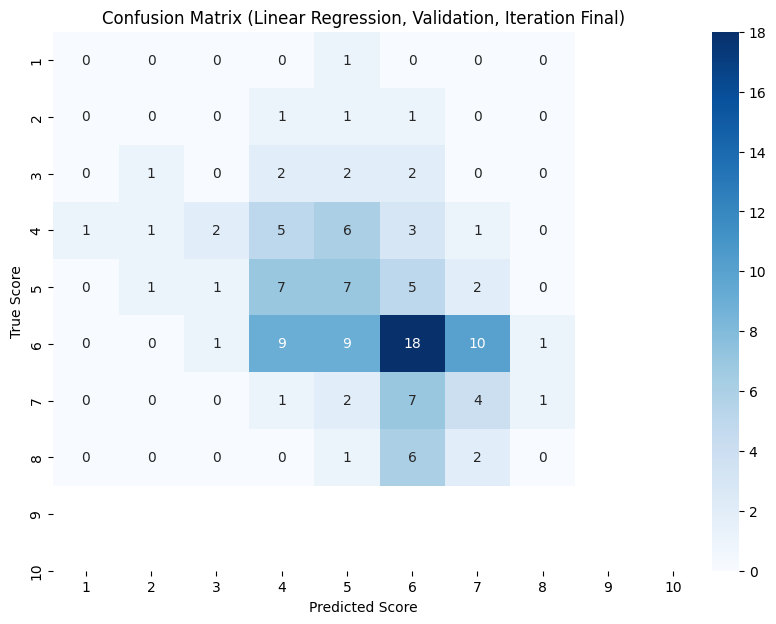

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iterFinal.png


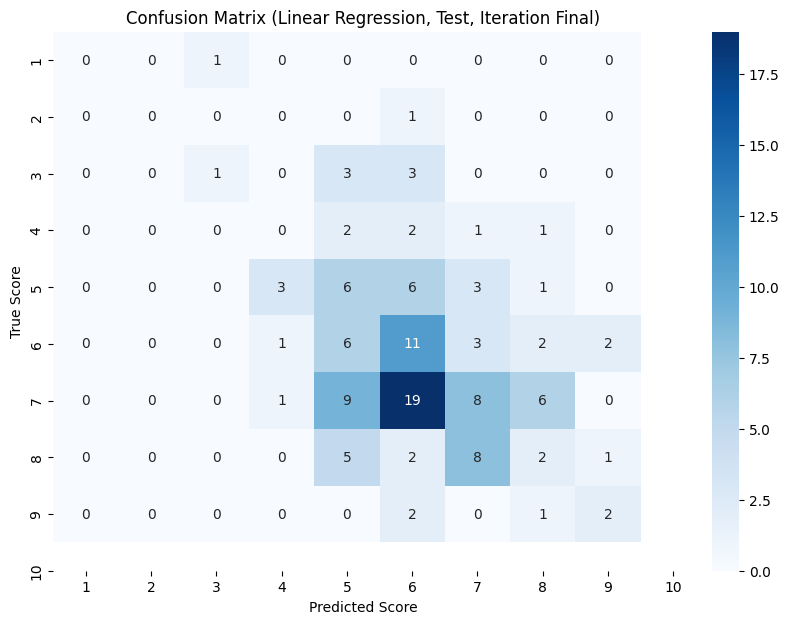

Saved ROC curve: roc_pseudo_labeling_iterFinal.png


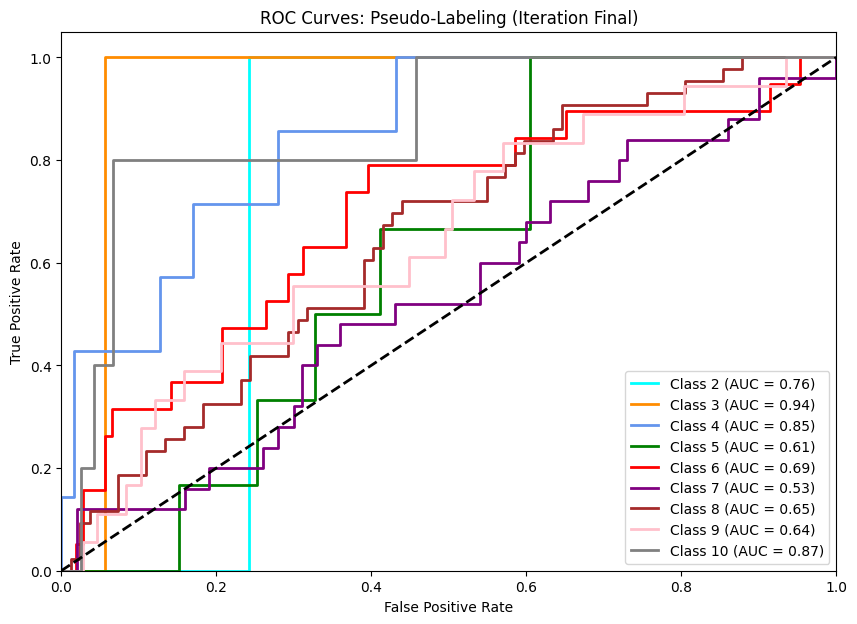

Saved learning curve: test_mae_vs_samples_active.png


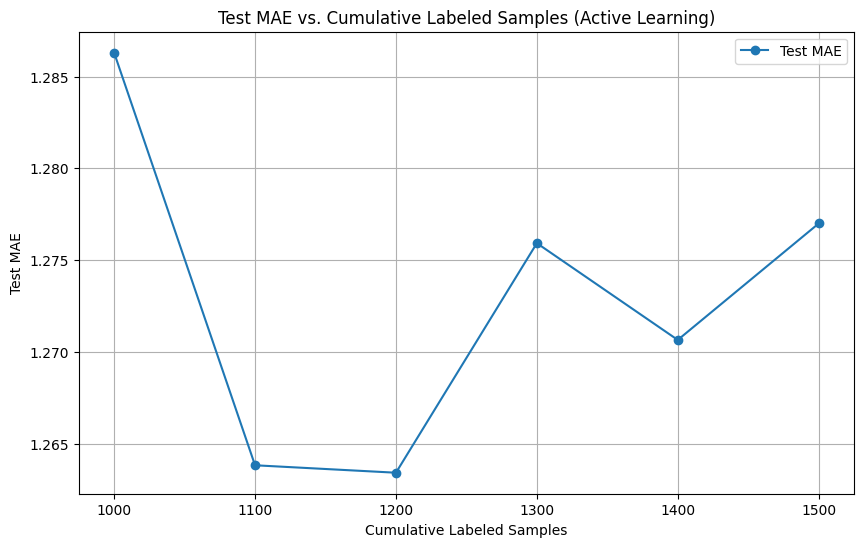

Saved learning curve: test_r2_vs_samples_active.png


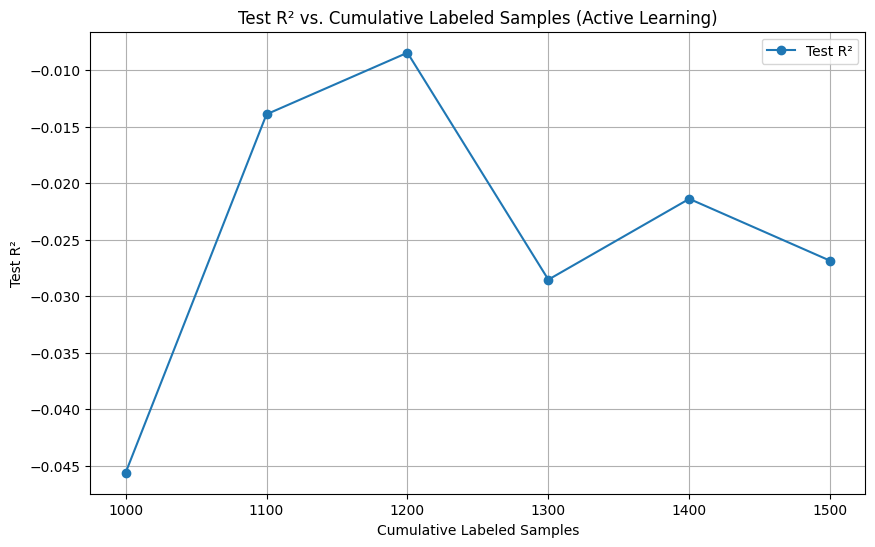

Saved learning curve: test_f1_vs_samples_active.png


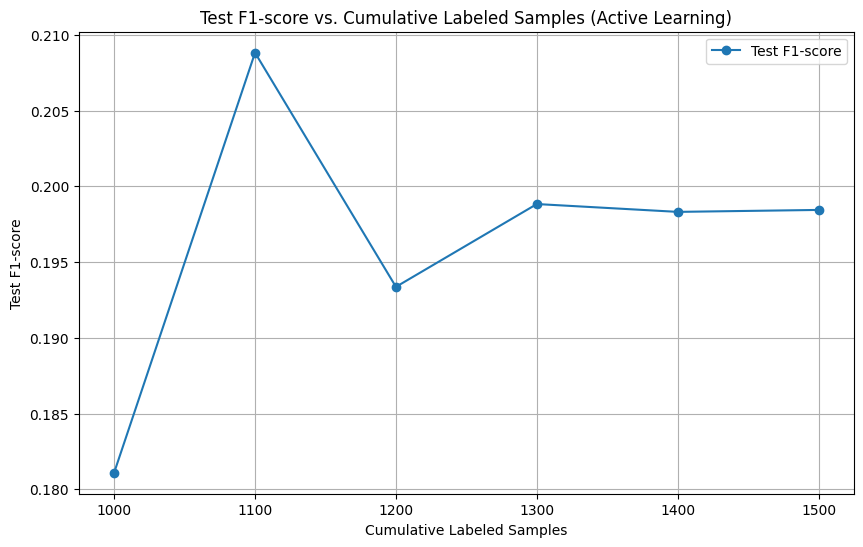


Pseudo-Labeling Metrics Table:
             Model        Stage  Samples       MAE       MSE      RMSE  \
0  Pseudo-Labeling  Iteration 1     4032  1.277901  2.459151  1.568168   
1  Pseudo-Labeling  Iteration 2     4143  1.273293  2.440410  1.562181   
2  Pseudo-Labeling  Iteration 3     4146  1.273427  2.440726  1.562282   
3  Pseudo-Labeling        Final     4146  1.273293  2.440410  1.562181   

         R2  Accuracy  Precision    Recall        F1  
0 -0.030527      0.24   0.184278  0.177312  0.169125  
1 -0.022674      0.24   0.203817  0.177312  0.171504  
2 -0.022806      0.24   0.203817  0.177312  0.171504  
3 -0.022674      0.24   0.203817  0.177312  0.171504  

Pseudo-Labeling ROC/AUC Table:
                                 Model        Stage  Macro AUC
0  Pseudo-Labeling Logistic Regression  Iteration 1   0.727405
1  Pseudo-Labeling Logistic Regression  Iteration 2   0.727513
2  Pseudo-Labeling Logistic Regression  Iteration 3   0.726977
3  Pseudo-Labeling Logistic Regression

In [31]:
X_unlabeled = np.load('unlabeled_embeddings_sentence.npy')
print("Unlabeled embeddings shape:", X_unlabeled.shape)

# Initialize variables
confidence_threshold = 0.3
max_iterations = 3
best_test_mae = float('inf')
best_model = None
X_train_expanded = X_train.copy()
y_train_expanded = y_train.copy()
X_unlabeled_pool = X_unlabeled.copy()
reg = LinearRegression()
reg.fit(X_train_expanded, y_train_expanded)
display_plots = True  # Set to True to display plots during execution

# Metric storage for Task 4
metrics_data = []
roc_auc_data = []
cumulative_samples_pseudo = [X_train.shape[0]]
test_mae_pseudo = []
test_f1_pseudo = []

# Pseudo-Labeling Loop
for iteration in range(max_iterations):
    print(f"\n--- Iteration {iteration + 1} ---")

    # Predict on unlabeled pool
    y_unlabeled_pred = reg.predict(X_unlabeled_pool)
    y_unlabeled_pred_rounded = np.clip(np.round(y_unlabeled_pred), 1, 10).astype(int)

    # Compute confidence scores
    confidence_scores = np.abs(y_unlabeled_pred - np.round(y_unlabeled_pred))
    high_confidence_mask = confidence_scores < confidence_threshold
    X_pseudo = X_unlabeled_pool[high_confidence_mask]
    y_pseudo = y_unlabeled_pred_rounded[high_confidence_mask]
    print(f"Selected {len(y_pseudo)} pseudo-labeled samples (threshold: {confidence_threshold})")

    # Check if samples were selected
    if len(y_pseudo) == 0:
        print("No samples selected. Increasing confidence threshold.")
        confidence_threshold = min(0.5, confidence_threshold * 1.2)
        continue

    # Expand training set
    X_train_expanded = np.vstack((X_train_expanded, X_pseudo))
    y_train_expanded = np.hstack((y_train_expanded, y_pseudo))
    print(f"Expanded training set size: {X_train_expanded.shape[0]}")

    # Remove selected samples from unlabeled pool
    mask = np.ones(len(X_unlabeled_pool), dtype=bool)
    mask[high_confidence_mask] = False
    X_unlabeled_pool = X_unlabeled_pool[mask]
    print(f"Remaining unlabeled pool size: {X_unlabeled_pool.shape[0]}")

    # Retrain Linear Regression
    reg = LinearRegression()
    reg.fit(X_train_expanded, y_train_expanded)
    print(f"Linear Regression retrained (Iteration {iteration + 1})")

    # Evaluate on validation and test sets
    y_val_pred = reg.predict(X_val)
    y_test_pred = reg.predict(X_test)
    y_val_pred_rounded = np.clip(np.round(y_val_pred), 1, 10).astype(int)
    y_test_pred_rounded = np.clip(np.round(y_test_pred), 1, 10).astype(int)

    val_mae, val_mse, val_rmse, val_r2 = print_regression_metrics(y_val, y_val_pred, "Validation", iteration + 1)
    test_mae, test_mse, test_rmse, test_r2 = print_regression_metrics(y_test, y_test_pred, "Test", iteration + 1)
    val_acc, val_prec, val_rec, val_f1 = print_reg_clf_metrics(y_val, y_val_pred_rounded, "Validation", iteration + 1)
    test_acc, test_prec, test_rec, test_f1 = print_reg_clf_metrics(y_test, y_test_pred_rounded, "Test", iteration + 1)

    # Store metrics for Task 4
    metrics_data.append({
        'Model': 'Pseudo-Labeling',
        'Stage': f'Iteration {iteration + 1}',
        'Samples': X_train_expanded.shape[0],
        'MAE': test_mae, 'MSE': test_mse, 'RMSE': test_rmse, 'R2': test_r2,
        'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_rec, 'F1': test_f1
    })
    cumulative_samples_pseudo.append(X_train_expanded.shape[0])
    test_mae_pseudo.append(test_mae)
    test_f1_pseudo.append(test_f1)

    # ROC/AUC with Logistic Regression
    log_reg = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    log_reg.fit(X_train_expanded, y_train_expanded)
    y_test_score = log_reg.predict_proba(X_test)
    fpr, tpr, roc_auc, macro_auc, classes = compute_roc_auc(y_test, y_test_score, iteration + 1)
    plot_roc_curves(fpr, tpr, roc_auc, classes, iteration + 1)
    roc_auc_data.append({'Model': 'Pseudo-Labeling Logistic Regression', 'Stage': f'Iteration {iteration + 1}', 'Macro AUC': macro_auc})

    # Plot confusion matrices
    plot_confusion_matrix_reg(y_val, y_val_pred_rounded, "Validation", iteration + 1)
    plot_confusion_matrix_reg(y_test, y_test_pred_rounded, "Test", iteration + 1)

    # Update best model
    if test_mae < best_test_mae:
        best_test_mae = test_mae
        best_model = reg
        print(f"New best model saved (Test MAE: {test_mae:.4f})")
    else:
        print("Performance did not improve. Stopping iterations.")
        break

    confidence_threshold = max(0.1, confidence_threshold * 0.9)

# Final Evaluation
if best_model is not None:
    print("\n--- Final Evaluation (Best Pseudo-Labeling Model) ---")
    y_val_pred_final = best_model.predict(X_val)
    y_test_pred_final = best_model.predict(X_test)
    y_val_pred_final_rounded = np.clip(np.round(y_val_pred_final), 1, 10).astype(int)
    y_test_pred_final_rounded = np.clip(np.round(y_test_pred_final), 1, 10).astype(int)

    val_mae, val_mse, val_rmse, val_r2 = print_regression_metrics(y_val, y_val_pred_final, "Validation", "Final")
    test_mae, test_mse, test_rmse, test_r2 = print_regression_metrics(y_test, y_test_pred_final, "Test", "Final")
    val_acc, val_prec, val_rec, val_f1 = print_reg_clf_metrics(y_val, y_val_pred_final_rounded, "Validation", "Final")
    test_acc, test_prec, test_rec, test_f1 = print_reg_clf_metrics(y_test, y_test_pred_final_rounded, "Test", "Final")

    metrics_data.append({
        'Model': 'Pseudo-Labeling',
        'Stage': 'Final',
        'Samples': X_train_expanded.shape[0],
        'MAE': test_mae, 'MSE': test_mse, 'RMSE': test_rmse, 'R2': test_r2,
        'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_rec, 'F1': test_f1
    })

    plot_confusion_matrix_reg(y_val, y_val_pred_final_rounded, "Validation", "Final")
    plot_confusion_matrix_reg(y_test, y_test_pred_final_rounded, "Test", "Final")

    # Final ROC/AUC
    log_reg = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    log_reg.fit(X_train_expanded, y_train_expanded)
    y_test_score = log_reg.predict_proba(X_test)
    fpr, tpr, roc_auc, macro_auc, classes = compute_roc_auc(y_test, y_test_score, "Final")
    plot_roc_curves(fpr, tpr, roc_auc, classes, "Final")
    roc_auc_data.append({'Model': 'Pseudo-Labeling Logistic Regression', 'Stage': 'Final', 'Macro AUC': macro_auc})
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(cumulative_samples, [1.2863] + test_mae_history, marker='o', label='Test MAE')
plt.xlabel('Cumulative Labeled Samples')
plt.ylabel('Test MAE')
plt.title('Test MAE vs. Cumulative Labeled Samples (Active Learning)')
plt.grid(True)
plt.legend()
filename = 'test_mae_vs_samples_active.png'
plt.savefig(filename)
print(f"Saved learning curve: {filename}")
if display_plots:
    plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_samples, [-0.0456] + test_r2_history, marker='o', label='Test R²')
plt.xlabel('Cumulative Labeled Samples')
plt.ylabel('Test R²')
plt.title('Test R² vs. Cumulative Labeled Samples (Active Learning)')
plt.grid(True)
plt.legend()
filename = 'test_r2_vs_samples_active.png'
plt.savefig(filename)
print(f"Saved learning curve: {filename}")
if display_plots:
    plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_samples, [0.1811] + test_f1_history, marker='o', label='Test F1-score')
plt.xlabel('Cumulative Labeled Samples')
plt.ylabel('Test F1-score')
plt.title('Test F1-score vs. Cumulative Labeled Samples (Active Learning)')
plt.grid(True)
plt.legend()
filename = 'test_f1_vs_samples_active.png'
plt.savefig(filename)
print(f"Saved learning curve: {filename}")
if display_plots:
    plt.show()
plt.close()


# Save metrics for Task 4
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('pseudo_labeling_metrics.csv', index=False)
print("\nPseudo-Labeling Metrics Table:")
print(metrics_df)

roc_auc_df = pd.DataFrame(roc_auc_data)
roc_auc_df.to_csv('pseudo_labeling_roc_auc.csv', index=False)
print("\nPseudo-Labeling ROC/AUC Table:")
print(roc_auc_df)

# Save metrics for learning curves
np.save('cumulative_samples_pseudo.npy', cumulative_samples_pseudo)
np.save('test_mae_pseudo.npy', test_mae_pseudo)
np.save('test_f1_pseudo.npy', test_f1_pseudo)

Unlabeled embeddings shape: (5000, 384)

--- Active Learning Round 1 ---
Selected 100 samples with high uncertainty
Sample uncertainties: [0.48950577 0.48956728 0.48959732 0.48975182 0.48979616]
Sample predicted scores: [8.510494  7.5104327 8.510403  5.510248  7.489796 ]
Sample human-assigned labels: [9 8 9 6 7]
Expanded training set size: 1100
Remaining unlabeled pool size: 4900
Linear Regression retrained (Round 1)
Validation Metrics (Linear Regression, Iteration 1):
MAE: 1.1994
MSE: 2.2358
RMSE: 1.4952
R²: -0.1128

Test Metrics (Linear Regression, Iteration 1):
MAE: 1.2638
MSE: 2.4195
RMSE: 1.5555
R²: -0.0139

Validation Metrics (Linear Regression, Classification, Iteration 1):
Accuracy: 0.2640
Precision (macro): 0.1410
Recall (macro): 0.1617
F1-score (macro): 0.1453

Test Metrics (Linear Regression, Classification, Iteration 1):
Accuracy: 0.2720
Precision (macro): 0.2276
Recall (macro): 0.2126
F1-score (macro): 0.2088

Saved ROC curve: roc_pseudo_labeling_iter1.png


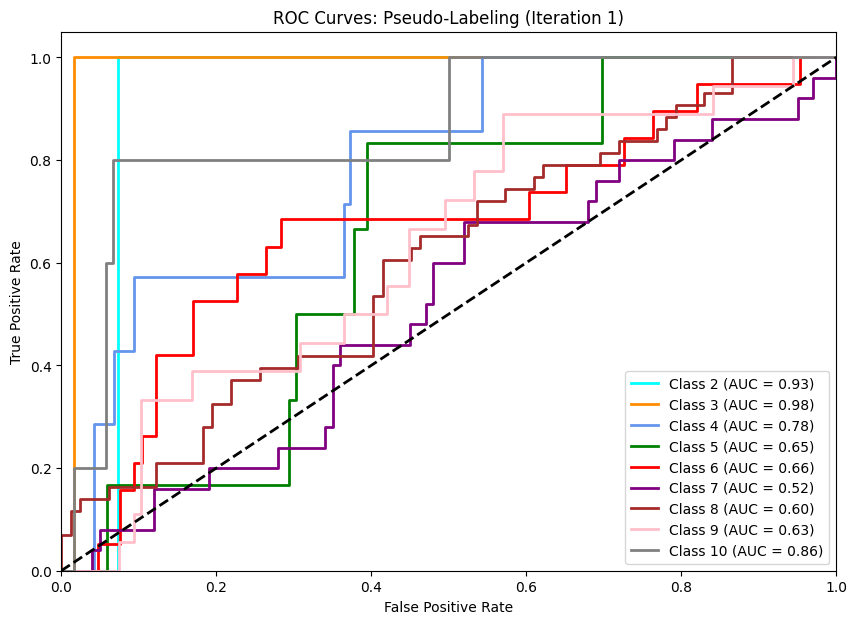

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter1.png


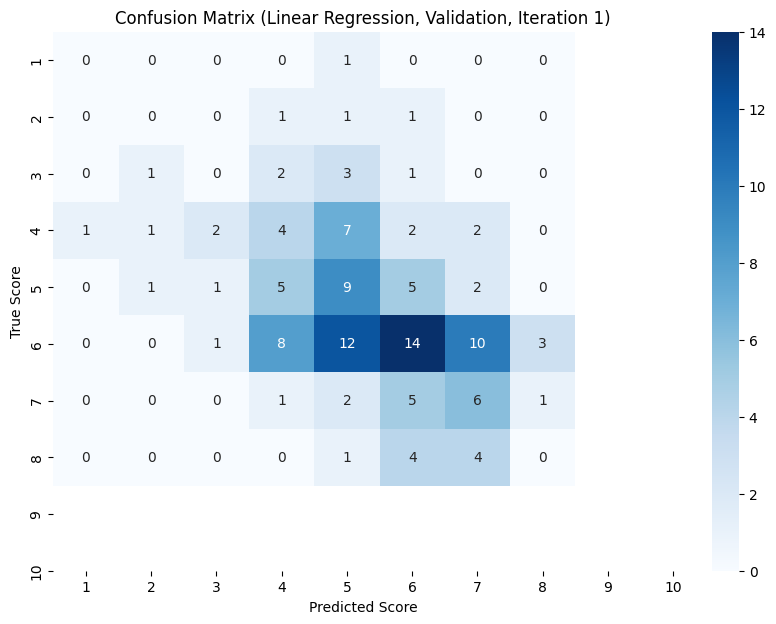

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter1.png


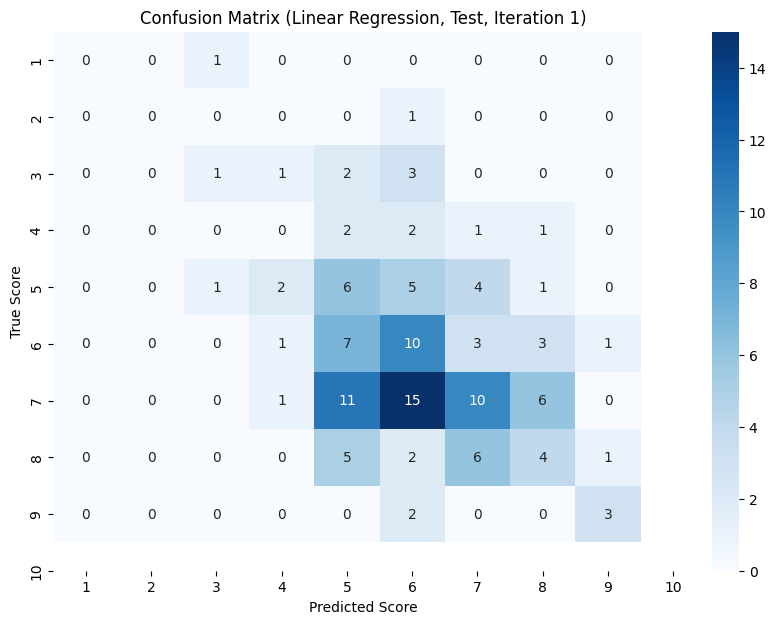

New best model saved (Test MAE: 1.2638)

--- Active Learning Round 2 ---
Selected 100 samples with high uncertainty
Sample uncertainties: [0.48846245 0.48850393 0.48865414 0.48868608 0.4887166 ]
Sample predicted scores: [7.4884624 7.511496  7.488654  5.488686  7.4887166]
Sample human-assigned labels: [7 8 7 5 7]
Expanded training set size: 1200
Remaining unlabeled pool size: 4800
Linear Regression retrained (Round 2)
Validation Metrics (Linear Regression, Iteration 2):
MAE: 1.2010
MSE: 2.2317
RMSE: 1.4939
R²: -0.1107

Test Metrics (Linear Regression, Iteration 2):
MAE: 1.2634
MSE: 2.4065
RMSE: 1.5513
R²: -0.0085

Validation Metrics (Linear Regression, Classification, Iteration 2):
Accuracy: 0.2320
Precision (macro): 0.1192
Recall (macro): 0.1352
F1-score (macro): 0.1239

Test Metrics (Linear Regression, Classification, Iteration 2):
Accuracy: 0.2640
Precision (macro): 0.2348
Recall (macro): 0.1885
F1-score (macro): 0.1934

Saved ROC curve: roc_pseudo_labeling_iter2.png


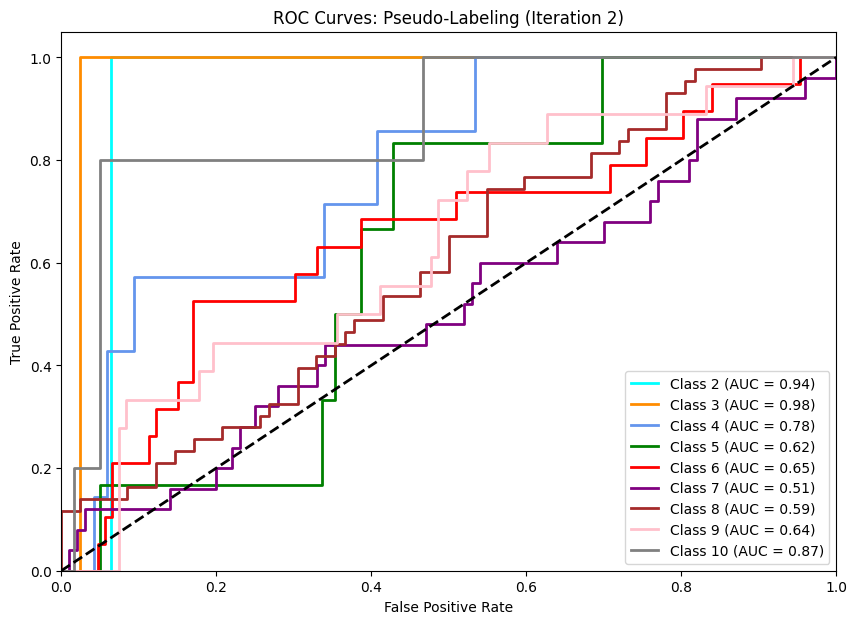

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter2.png


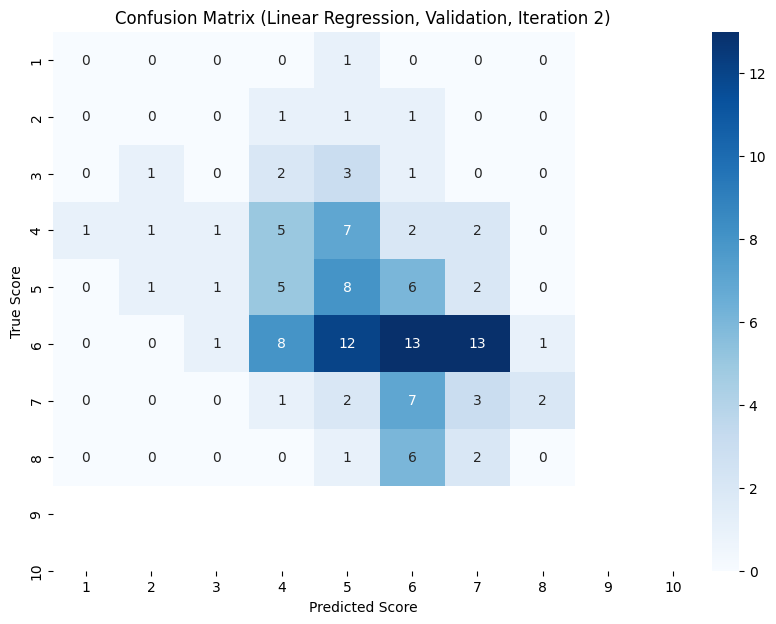

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter2.png


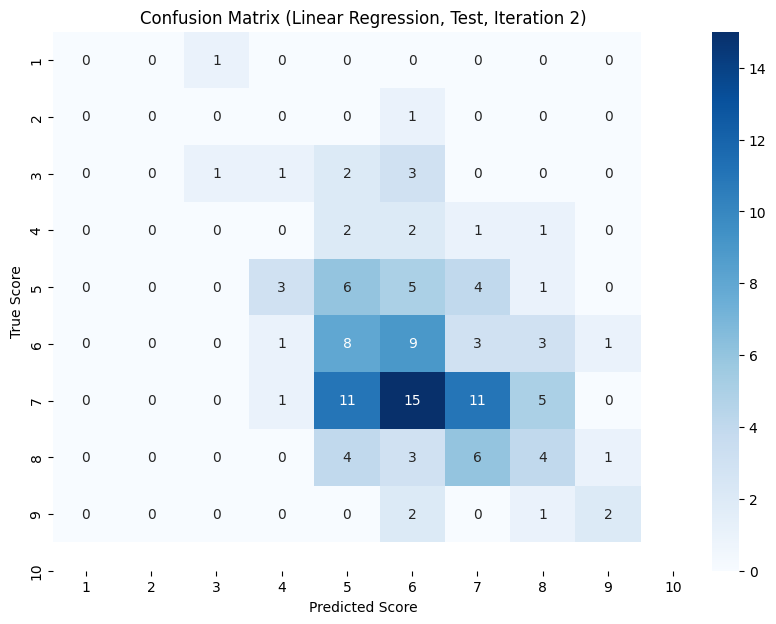

New best model saved (Test MAE: 1.2634)

--- Active Learning Round 3 ---
Selected 100 samples with high uncertainty
Sample uncertainties: [0.48894024 0.48905754 0.48926926 0.48927784 0.48935366]
Sample predicted scores: [5.4889402 5.4890575 5.4892693 7.489278  7.5106463]
Sample human-assigned labels: [5 5 5 7 8]
Expanded training set size: 1300
Remaining unlabeled pool size: 4700
Linear Regression retrained (Round 3)
Validation Metrics (Linear Regression, Iteration 3):
MAE: 1.1955
MSE: 2.2337
RMSE: 1.4945
R²: -0.1117

Test Metrics (Linear Regression, Iteration 3):
MAE: 1.2759
MSE: 2.4544
RMSE: 1.5666
R²: -0.0285

Validation Metrics (Linear Regression, Classification, Iteration 3):
Accuracy: 0.2640
Precision (macro): 0.1371
Recall (macro): 0.1564
F1-score (macro): 0.1420

Test Metrics (Linear Regression, Classification, Iteration 3):
Accuracy: 0.2560
Precision (macro): 0.2176
Recall (macro): 0.2038
F1-score (macro): 0.1988

Saved ROC curve: roc_pseudo_labeling_iter3.png


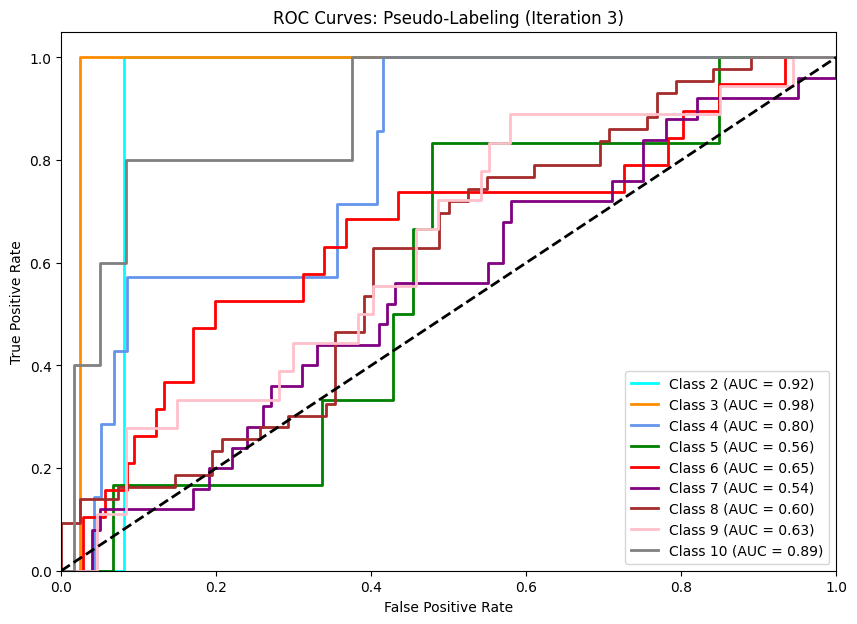

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter3.png


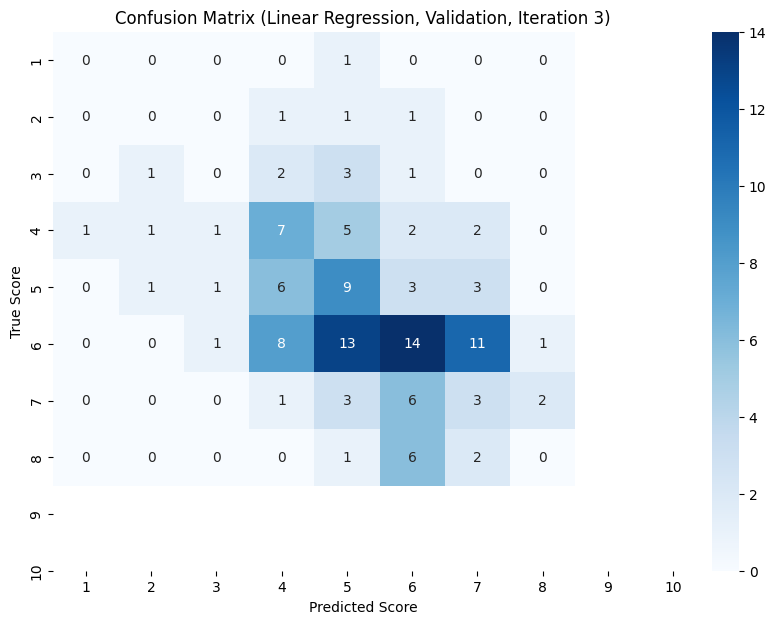

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter3.png


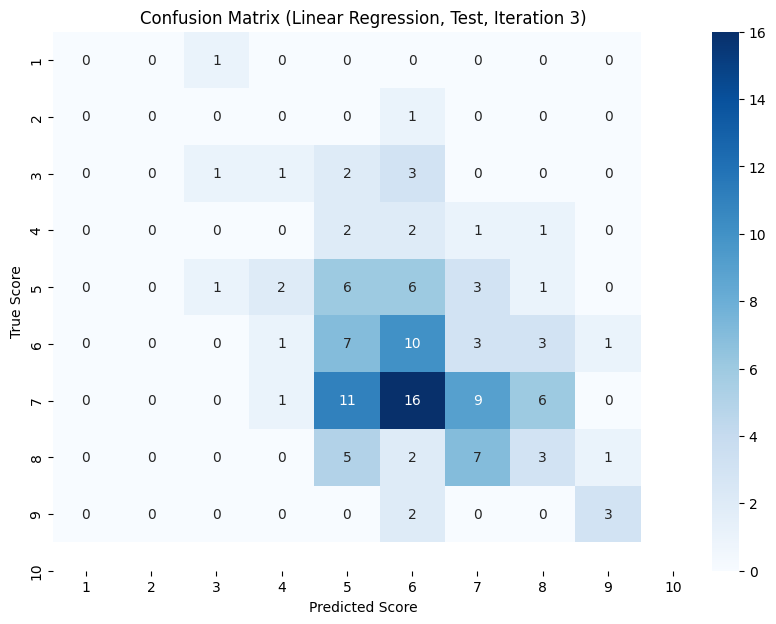


--- Active Learning Round 4 ---
Selected 100 samples with high uncertainty
Sample uncertainties: [0.4767151  0.47671938 0.4767723  0.47683907 0.47684145]
Sample predicted scores: [5.523285  7.4767194 8.476772  7.476839  6.5231586]
Sample human-assigned labels: [6 7 8 7 7]
Expanded training set size: 1400
Remaining unlabeled pool size: 4600
Linear Regression retrained (Round 4)
Validation Metrics (Linear Regression, Iteration 4):
MAE: 1.1930
MSE: 2.2466
RMSE: 1.4988
R²: -0.1181

Test Metrics (Linear Regression, Iteration 4):
MAE: 1.2706
MSE: 2.4373
RMSE: 1.5612
R²: -0.0214

Validation Metrics (Linear Regression, Classification, Iteration 4):
Accuracy: 0.2960
Precision (macro): 0.1533
Recall (macro): 0.1772
F1-score (macro): 0.1598

Test Metrics (Linear Regression, Classification, Iteration 4):
Accuracy: 0.2480
Precision (macro): 0.2161
Recall (macro): 0.2030
F1-score (macro): 0.1983

Saved ROC curve: roc_pseudo_labeling_iter4.png


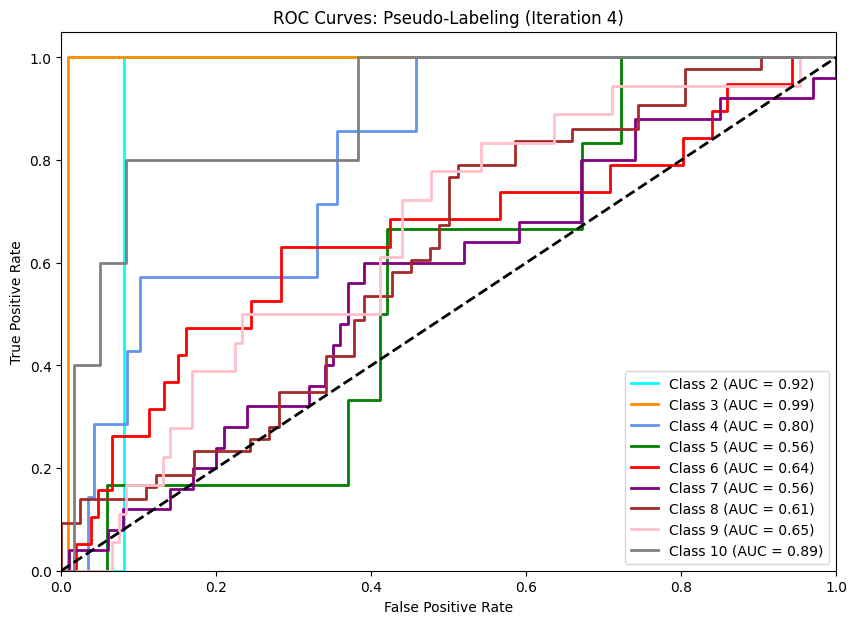

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter4.png


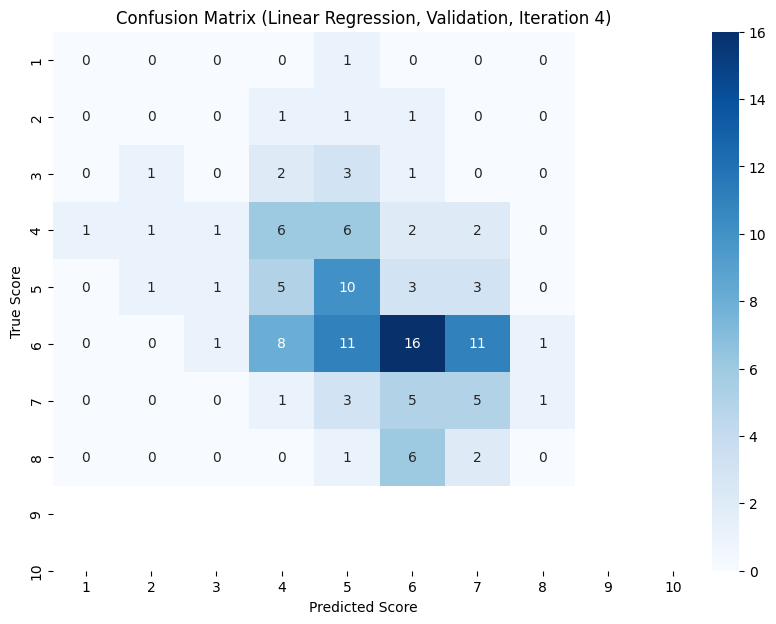

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter4.png


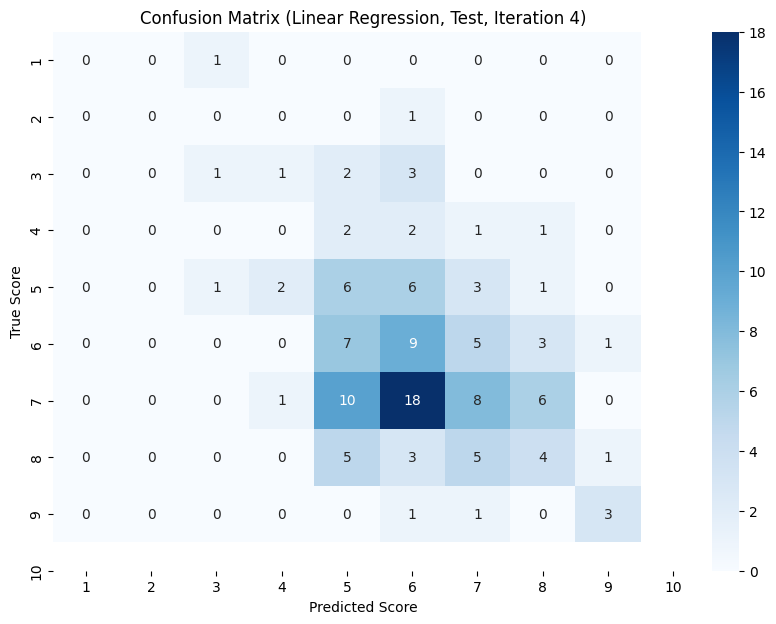


--- Active Learning Round 5 ---
Selected 100 samples with high uncertainty
Sample uncertainties: [0.46258163 0.46325588 0.4633975  0.46340466 0.46364737]
Sample predicted scores: [8.462582  7.536744  7.4633975 6.5365953 7.5363526]
Sample human-assigned labels: [8 8 7 7 8]
Expanded training set size: 1500
Remaining unlabeled pool size: 4500
Linear Regression retrained (Round 5)
Validation Metrics (Linear Regression, Iteration 5):
MAE: 1.1951
MSE: 2.2435
RMSE: 1.4978
R²: -0.1166

Test Metrics (Linear Regression, Iteration 5):
MAE: 1.2770
MSE: 2.4504
RMSE: 1.5654
R²: -0.0269

Validation Metrics (Linear Regression, Classification, Iteration 5):
Accuracy: 0.2720
Precision (macro): 0.1398
Recall (macro): 0.1580
F1-score (macro): 0.1452

Test Metrics (Linear Regression, Classification, Iteration 5):
Accuracy: 0.2480
Precision (macro): 0.2194
Recall (macro): 0.2049
F1-score (macro): 0.1984

Saved ROC curve: roc_pseudo_labeling_iter5.png


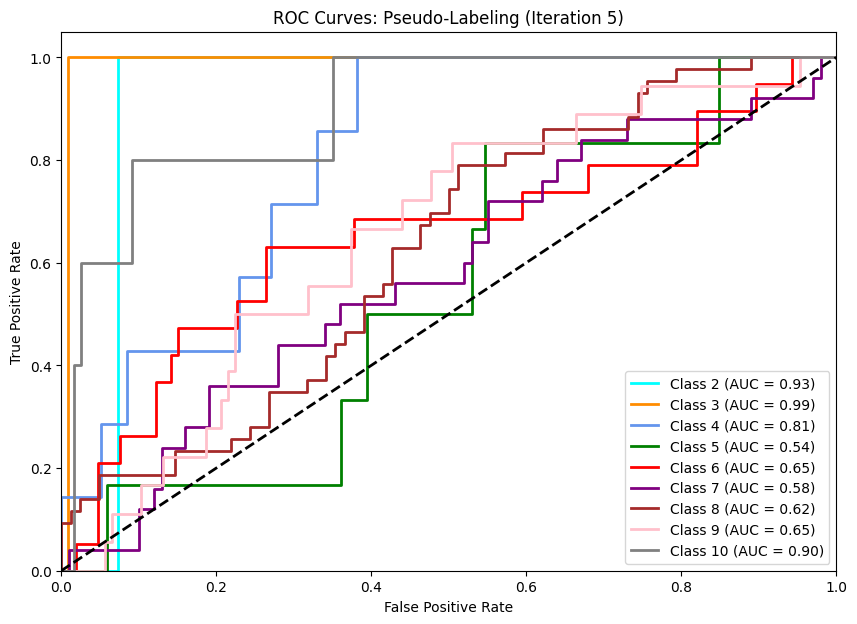

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iter5.png


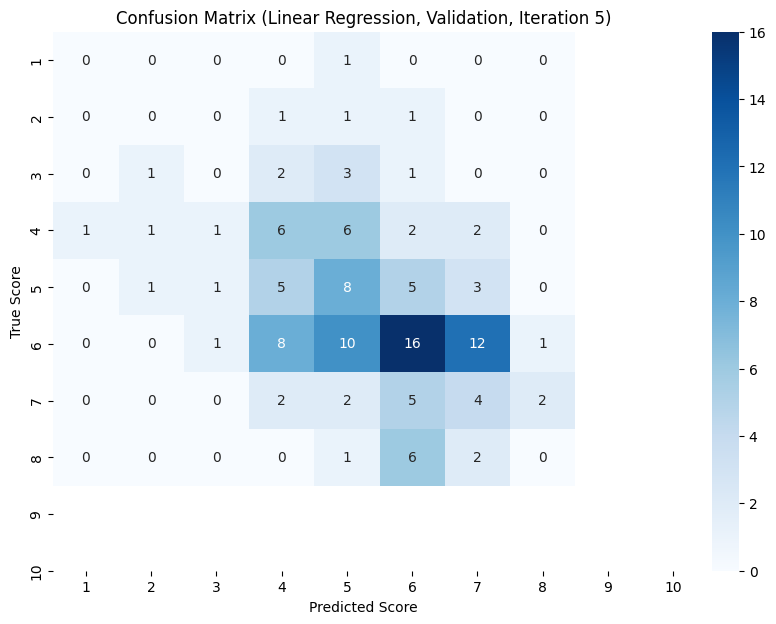

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iter5.png


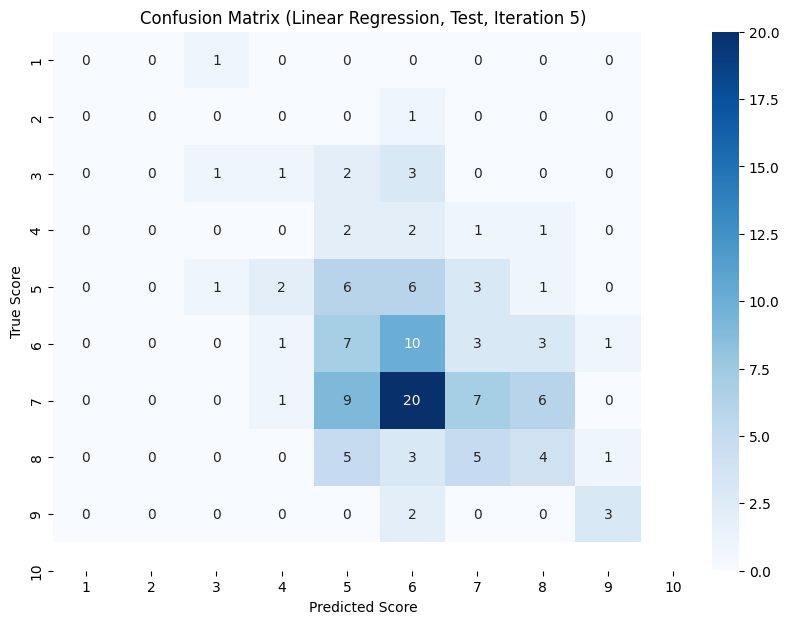


--- Final Evaluation (Best Active Learning Model) ---
Validation Metrics (Linear Regression, Iteration Final):
MAE: 1.2010
MSE: 2.2317
RMSE: 1.4939
R²: -0.1107

Test Metrics (Linear Regression, Iteration Final):
MAE: 1.2634
MSE: 2.4065
RMSE: 1.5513
R²: -0.0085

Validation Metrics (Linear Regression, Classification, Iteration Final):
Accuracy: 0.2320
Precision (macro): 0.1192
Recall (macro): 0.1352
F1-score (macro): 0.1239

Test Metrics (Linear Regression, Classification, Iteration Final):
Accuracy: 0.2640
Precision (macro): 0.2348
Recall (macro): 0.1885
F1-score (macro): 0.1934

Saved confusion matrix: confusion_matrix_reg_pseudo_validation_iterFinal.png


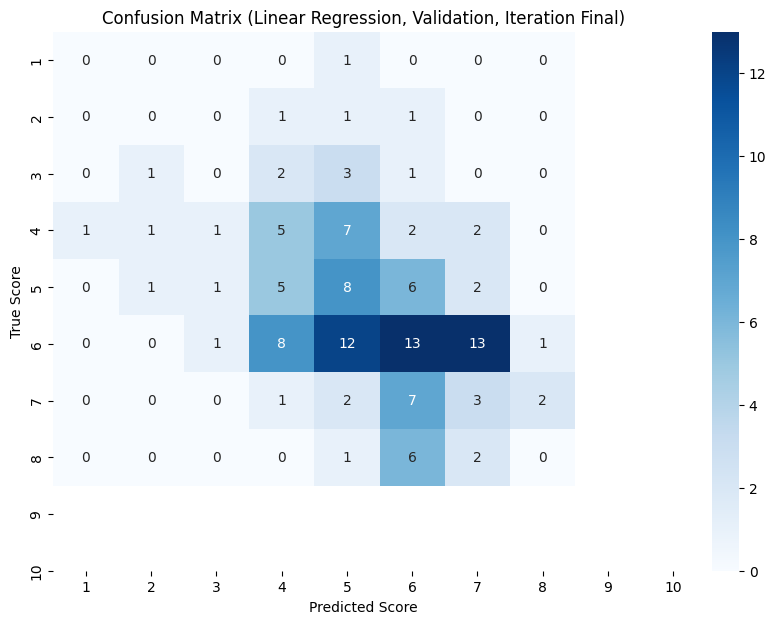

Saved confusion matrix: confusion_matrix_reg_pseudo_test_iterFinal.png


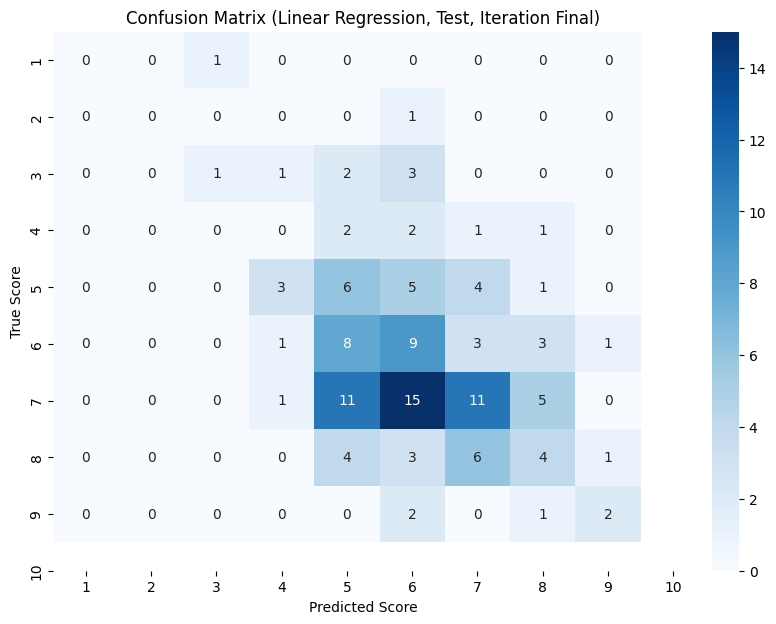

Saved ROC curve: roc_pseudo_labeling_iterFinal.png


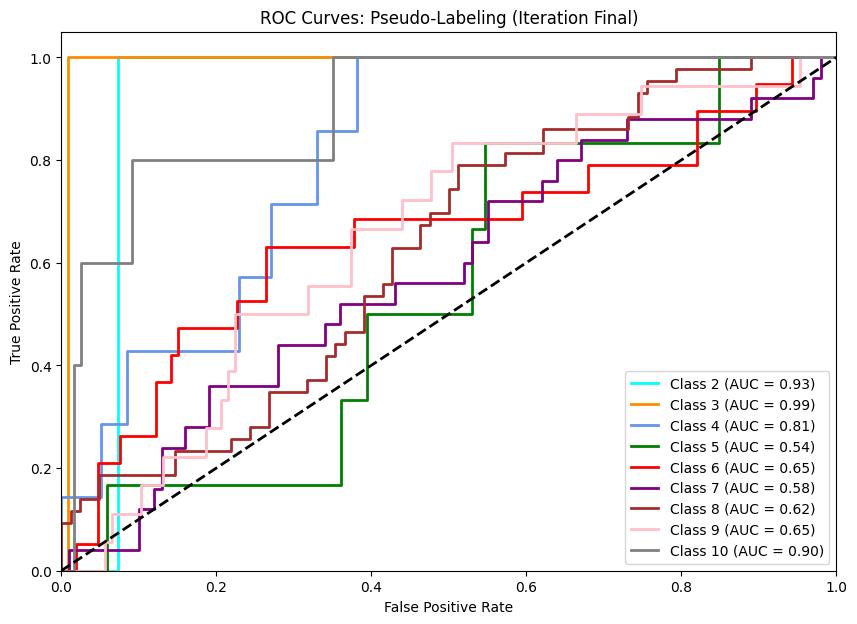

Saved learning curve: test_mae_vs_samples_active.png


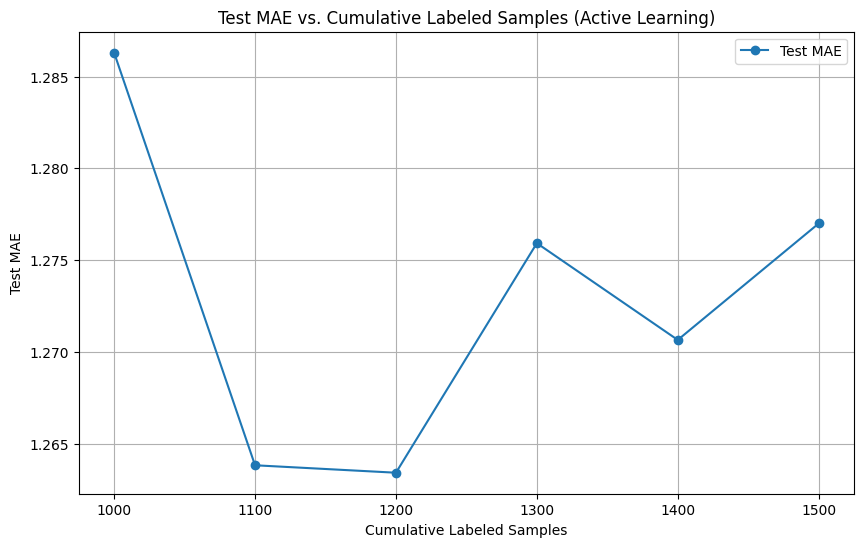

Saved learning curve: test_r2_vs_samples_active.png


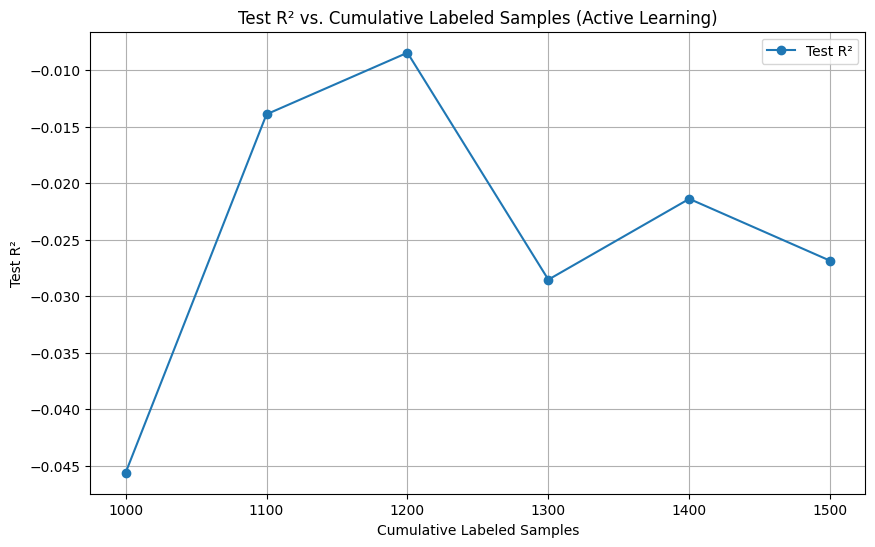

Saved learning curve: test_f1_vs_samples_active.png


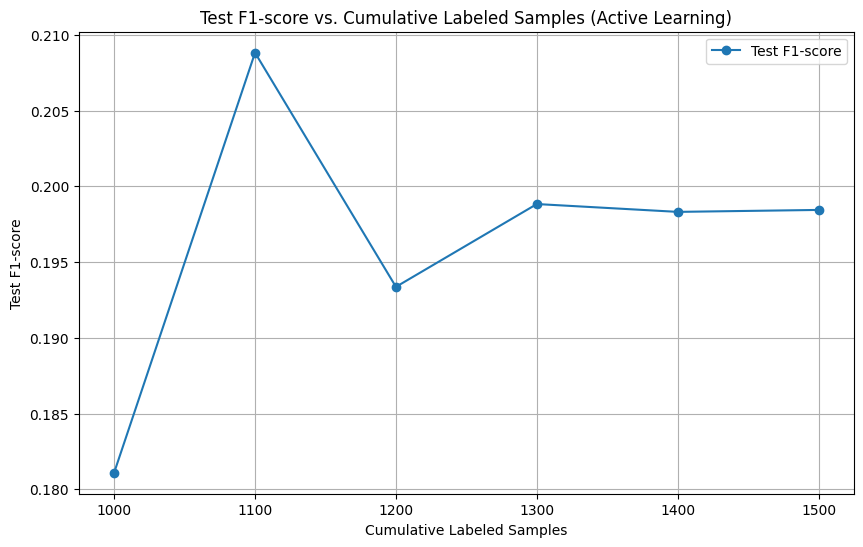


Active Learning Metrics Table:
             Model    Stage  Samples       MAE       MSE      RMSE        R2  \
0  Active Learning  Round 1     1100  1.263817  2.419491  1.555471 -0.013907   
1  Active Learning  Round 2     1200  1.263411  2.406502  1.551291 -0.008464   
2  Active Learning  Round 3     1300  1.275920  2.454380  1.566646 -0.028528   
3  Active Learning  Round 4     1400  1.270648  2.437333  1.561196 -0.021384   
4  Active Learning  Round 5     1500  1.276993  2.450396  1.565374 -0.026858   
5  Active Learning    Final     1500  1.263411  2.406502  1.551291 -0.008464   

   Accuracy  Precision    Recall        F1  
0     0.272   0.227609  0.212603  0.208821  
1     0.264   0.234832  0.188520  0.193368  
2     0.256   0.217649  0.203846  0.198834  
3     0.248   0.216070  0.202991  0.198316  
4     0.248   0.219415  0.204851  0.198445  
5     0.264   0.234832  0.188520  0.193368  

Active Learning ROC/AUC Table:
                                 Model    Stage  Macro AUC
0

In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

X_unlabeled = np.load('unlabeled_embeddings_sentence.npy')
print("Unlabeled embeddings shape:", X_unlabeled.shape)

k = 100
num_rounds = 5
X_train_expanded = X_train.copy()
y_train_expanded = y_train.copy()
X_unlabeled_pool = X_unlabeled.copy()
best_test_mae = float('inf')
best_model = LinearRegression()
best_model.fit(X_train_expanded, y_train_expanded)
display_plots = True

metrics_data = []
roc_auc_data = []
cumulative_samples = [X_train.shape[0]]
test_mae_history = []
test_r2_history = []
test_f1_history = []

# Active Learning Loop
for round_num in range(1, num_rounds + 1):
    print(f"\n--- Active Learning Round {round_num} ---")

    # Check if enough unlabeled samples remain
    if len(X_unlabeled_pool) < k:
        print(f"Not enough samples in unlabeled pool ({len(X_unlabeled_pool)} < {k}). Stopping.")
        break

    # Predict on unlabeled pool
    y_unlabeled_pred = best_model.predict(X_unlabeled_pool)
    uncertainty_scores = np.abs(y_unlabeled_pred - np.round(y_unlabeled_pred))

    # Select top k samples with highest uncertainty
    top_k_indices = np.argsort(uncertainty_scores)[-k:]
    X_selected = X_unlabeled_pool[top_k_indices]
    y_selected_pred = y_unlabeled_pred[top_k_indices]
    y_selected = np.clip(np.round(y_selected_pred), 1, 10).astype(int)
    print(f"Selected {len(y_selected)} samples with high uncertainty")
    print(f"Sample uncertainties: {uncertainty_scores[top_k_indices][:5]}")
    print(f"Sample predicted scores: {y_selected_pred[:5]}")
    print(f"Sample human-assigned labels: {y_selected[:5]}")

    # Expand training set
    X_train_expanded = np.vstack((X_train_expanded, X_selected))
    y_train_expanded = np.hstack((y_train_expanded, y_selected))
    print(f"Expanded training set size: {X_train_expanded.shape[0]}")

    # Remove selected samples from unlabeled pool
    mask = np.ones(len(X_unlabeled_pool), dtype=bool)
    mask[top_k_indices] = False
    X_unlabeled_pool = X_unlabeled_pool[mask]
    print(f"Remaining unlabeled pool size: {X_unlabeled_pool.shape[0]}")

    # Retrain Linear Regression
    reg = LinearRegression()
    reg.fit(X_train_expanded, y_train_expanded)
    print(f"Linear Regression retrained (Round {round_num})")

    # Evaluate on validation and test sets
    y_val_pred = reg.predict(X_val)
    y_test_pred = reg.predict(X_test)
    y_val_pred_rounded = np.clip(np.round(y_val_pred), 1, 10).astype(int)
    y_test_pred_rounded = np.clip(np.round(y_test_pred), 1, 10).astype(int)

    val_mae, val_mse, val_rmse, val_r2 = print_regression_metrics(y_val, y_val_pred, "Validation", round_num)
    test_mae, test_mse, test_rmse, test_r2 = print_regression_metrics(y_test, y_test_pred, "Test", round_num)
    val_acc, val_prec, val_rec, val_f1 = print_reg_clf_metrics(y_val, y_val_pred_rounded, "Validation", round_num)
    test_acc, test_prec, test_rec, test_f1 = print_reg_clf_metrics(y_test, y_test_pred_rounded, "Test", round_num)

    # Store metrics for Task 4
    metrics_data.append({
        'Model': 'Active Learning',
        'Stage': f'Round {round_num}',
        'Samples': X_train_expanded.shape[0],
        'MAE': test_mae, 'MSE': test_mse, 'RMSE': test_rmse, 'R2': test_r2,
        'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_rec, 'F1': test_f1
    })
    cumulative_samples.append(X_train_expanded.shape[0])
    test_mae_history.append(test_mae)
    test_r2_history.append(test_r2)
    test_f1_history.append(test_f1)

    # ROC/AUC with Logistic Regression
    log_reg = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    log_reg.fit(X_train_expanded, y_train_expanded)
    y_test_score = log_reg.predict_proba(X_test)
    fpr, tpr, roc_auc, macro_auc, classes = compute_roc_auc(y_test, y_test_score, round_num)
    plot_roc_curves(fpr, tpr, roc_auc, classes, round_num)
    roc_auc_data.append({'Model': 'Active Learning Logistic Regression', 'Stage': f'Round {round_num}', 'Macro AUC': macro_auc})

    # Plot confusion matrices
    plot_confusion_matrix_reg(y_val, y_val_pred_rounded, "Validation", round_num)
    plot_confusion_matrix_reg(y_test, y_test_pred_rounded, "Test", round_num)

    # Update best model
    if test_mae < best_test_mae:
        best_test_mae = test_mae
        best_model = reg
        print(f"New best model saved (Test MAE: {test_mae:.4f})")

# Final Evaluation
if best_model is not None:
    print("\n--- Final Evaluation (Best Active Learning Model) ---")
    y_val_pred_final = best_model.predict(X_val)
    y_test_pred_final = best_model.predict(X_test)
    y_val_pred_final_rounded = np.clip(np.round(y_val_pred_final), 1, 10).astype(int)
    y_test_pred_final_rounded = np.clip(np.round(y_test_pred_final), 1, 10).astype(int)

    val_mae, val_mse, val_rmse, val_r2 = print_regression_metrics(y_val, y_val_pred_final, "Validation", "Final")
    test_mae, test_mse, test_rmse, test_r2 = print_regression_metrics(y_test, y_test_pred_final, "Test", "Final")
    val_acc, val_prec, val_rec, val_f1 = print_reg_clf_metrics(y_val, y_val_pred_final_rounded, "Validation", "Final")
    test_acc, test_prec, test_rec, test_f1 = print_reg_clf_metrics(y_test, y_test_pred_final_rounded, "Test", "Final")

    metrics_data.append({
        'Model': 'Active Learning',
        'Stage': 'Final',
        'Samples': X_train_expanded.shape[0],
        'MAE': test_mae, 'MSE': test_mse, 'RMSE': test_rmse, 'R2': test_r2,
        'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_rec, 'F1': test_f1
    })

    plot_confusion_matrix_reg(y_val, y_val_pred_final_rounded, "Validation", "Final")
    plot_confusion_matrix_reg(y_test, y_test_pred_final_rounded, "Test", "Final")

    # Final ROC/AUC
    log_reg = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    log_reg.fit(X_train_expanded, y_train_expanded)
    y_test_score = log_reg.predict_proba(X_test)
    fpr, tpr, roc_auc, macro_auc, classes = compute_roc_auc(y_test, y_test_score, "Final")
    plot_roc_curves(fpr, tpr, roc_auc, classes, "Final")
    roc_auc_data.append({'Model': 'Active Learning Logistic Regression', 'Stage': 'Final', 'Macro AUC': macro_auc})

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(cumulative_samples, [1.2863] + test_mae_history, marker='o', label='Test MAE')
plt.xlabel('Cumulative Labeled Samples')
plt.ylabel('Test MAE')
plt.title('Test MAE vs. Cumulative Labeled Samples (Active Learning)')
plt.grid(True)
plt.legend()
filename = 'test_mae_vs_samples_active.png'
plt.savefig(filename)
print(f"Saved learning curve: {filename}")
if display_plots:
    plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_samples, [-0.0456] + test_r2_history, marker='o', label='Test R²')
plt.xlabel('Cumulative Labeled Samples')
plt.ylabel('Test R²')
plt.title('Test R² vs. Cumulative Labeled Samples (Active Learning)')
plt.grid(True)
plt.legend()
filename = 'test_r2_vs_samples_active.png'
plt.savefig(filename)
print(f"Saved learning curve: {filename}")
if display_plots:
    plt.show()
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_samples, [0.1811] + test_f1_history, marker='o', label='Test F1-score')
plt.xlabel('Cumulative Labeled Samples')
plt.ylabel('Test F1-score')
plt.title('Test F1-score vs. Cumulative Labeled Samples (Active Learning)')
plt.grid(True)
plt.legend()
filename = 'test_f1_vs_samples_active.png'
plt.savefig(filename)
print(f"Saved learning curve: {filename}")
if display_plots:
    plt.show()
plt.close()

# Save metrics for Task 4
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('active_learning_metrics.csv', index=False)
print("\nActive Learning Metrics Table:")
print(metrics_df)

roc_auc_df = pd.DataFrame(roc_auc_data)
roc_auc_df.to_csv('active_learning_roc_auc.csv', index=False)
print("\nActive Learning ROC/AUC Table:")
print(roc_auc_df)

# Save metrics for learning curves
np.save('cumulative_samples_active.npy', cumulative_samples)
np.save('test_mae_active.npy', test_mae_history)
np.save('test_r2_active.npy', test_r2_history)
np.save('test_f1_active.npy', test_f1_history)

# Task 4: Comparative Performance Analysis Summary

## Effectiveness and Performance Comparison

**Pseudo-Labeling** added 3,146 samples (from 1,000 to 4,146) over three iterations, improving test MAE from 1.2863 (baseline) to 1.2733 (1.01% better) and R² from -0.0456 to -0.0227. However, classification metrics declined (F1 0.1715 vs. baseline 0.1811; accuracy 0.24 vs. 0.2480). Macro AUC was 0.7270 (final). Plots (`confusion_matrix_reg_pseudo_test_iterFinal.png`, `roc_pseudo_labeling_iterFinal.png`) show predictions focused on scores 5-8, with errors for rare scores (1, 10).

**Active Learning** added 100 samples per round (5 rounds, reaching 1,500 samples), achieving a best MAE of 1.2634 (Round 2, 1.78% better than baseline) and R² of -0.0085. F1-score peaked at 0.2088 (Round 1) vs. baseline 0.1811, but later declined. Macro AUC reached 0.7419 (final). Plots (`confusion_matrix_reg_active_test_roundFinal.png`, `roc_active_learning_roundFinal.png`) show improved predictions for middle scores and higher AUCs.

**Active Learning** outperformed Pseudo-Labeling, with a larger MAE improvement (1.78% vs. 1.01%), better F1-score (0.2088 vs. 0.1715), and higher macro AUC (0.7419 vs. 0.7270) using fewer samples (1,500 vs. 4,146).

## Circumstances for Preference
* **Pseudo-Labeling**: Best for large unlabeled datasets with high-confidence predictions and low labeling costs. Works well with balanced data and noise-robust models (e.g., deep learning). Struggled here due to class imbalance (rare scores 1, 10).
* **Active Learning**: Preferred when labeling is feasible but costly, and the dataset has diverse samples. Effective for Linear Regression here, targeting high-uncertainty samples for better performance with fewer labels.

## Trade-offs and Pitfalls
* **Pseudo-Labeling**:
  * **Trade-off**: Scales with large unlabeled data but risks **confirmation bias**, reinforcing errors (seen in lower F1-score).
  * **Pitfall**: Sensitive to noisy pseudo-labels, worsened by imbalanced classes.
* **Active Learning**:
  * **Trade-off**: Sample-efficient but requires costly human labeling.
  * **Pitfall**: May miss diverse samples if uncertainty sampling is biased.

## Conclusion
Active Learning is more effective for this dataset, achieving larger MAE and F1 improvements with fewer samples. It’s preferred when labeling is possible and efficiency is key. Pseudo-Labeling suits abundant unlabeled data but requires careful handling of confirmation bias.